# 1. Importing Modules

## 1.1. Importing usual libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.signal import butter, filtfilt, detrend, decimate, correlate
import scipy
from scipy.signal import welch, csd, find_peaks
from scipy.linalg import svd


# !pip install plotly
import plotly.express as px
import datetime

from matplotlib.ticker import FuncFormatter, LogLocator
import importlib

plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 12

## 1.2. Imoprting modalyzer's functions

In [2]:
from modalyzer.EFDD import FDD_SVD_Diagram, FDD_ModeShape, FDD_Damping
from modalyzer.SSI import SSI_Alg, psd_func, svd_psd, stabilization_diagram
from modalyzer.PolyMAX import PolyMAX, independent_mode_shape
from modalyzer.Preprocess import preprocess, results_table, choose_modes
from modalyzer.ITD import ITD_alg
from modalyzer.ModeShape import draw_mode_shapes, draw_MAC_diagram

# 2. LUMO Data

## 2.1. Reading csv Files



In [5]:
# df_data = {'AU':pd.read_csv(f'E:/OMA desktop/Data_Qatar_intact/AU.csv', header = None)}
df_data = {'data':pd.read_csv('data_lumo.csv', header = None)}
# for i in range(1,5):
#     df[f'AD{i}'] = pd.read_csv(f'Data_Qatar_GS/AD{i}.csv', header = None)
df_data['data'].iloc[:,0:18]

0         1         2         3         4         5         6   \
0      0.006881  0.006544  0.004148  0.006658  0.003351  0.004837  0.002159   
1      0.006561  0.006874  0.003902  0.006582  0.003565  0.005111  0.002242   
2      0.006033  0.006817  0.003659  0.006582  0.003962  0.005346  0.002262   
3      0.006277  0.006985  0.003835  0.006727  0.003438  0.004898  0.002253   
4      0.006103  0.006624  0.004608  0.006202  0.002757  0.004541  0.002491   
...         ...       ...       ...       ...       ...       ...       ...   
99995 -0.000554  0.003405 -0.001018  0.004454 -0.000885  0.003169  0.000791   
99996 -0.000418  0.003816 -0.000627  0.003331 -0.000261  0.004729  0.000655   
99997 -0.000555  0.004518 -0.000528  0.003718  0.000888  0.004978  0.000600   
99998 -0.000312  0.003723 -0.000456  0.004867  0.001234  0.004014  0.000956   
99999  0.000248  0.003406 -0.000681  0.004949  0.000725  0.003067  0.001154   

             7         8         9         10        11        12        13  \
0      0.003571  0.001259  0.001025  0.000971  0.001493  0.000165  0.000343   
1      0.003172  0.001439  0.001572  0.001119  0.001283  0.000140  0.000465   
2      0.002770  0.001460  0.002544  0.000790  0.000939  0.000231  0.000544   
3      0.002482  0.001413  0.003109  0.000240  0.000615  0.000350  0.000502   
4      0.002469  0.001577  0.003073  0.000367  0.000651  0.000338  0.000462   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.004276  0.000708  0.004270  0.000307  0.001018  0.000473  0.002363   
99996  0.004176  0.001044  0.003857  0.000777  0.001540  0.000344  0.002902   
99997  0.004003  0.000640  0.003022  0.001078  0.002453  0.000382  0.002869   
99998  0.003989  0.000766  0.002492  0.000726  0.002737  0.000484  0.002763   
99999  0.003687  0.001358  0.002426  0.000844  0.002880  0.000384  0.002369   

             14        15        16        17  
0      0.000504 -0.000334  0.000028  0.000187  
1      0.000402 -0.000203  0.000166 -0.000165  
2      0.000079 -0.000021  0.000345 -0.000197  
3      0.000010  0.000081  0.000323 -0.000270  
4      0.000114  0.000104  0.000027 -0.000088  
...         ...       ...       ...       ...  
99995  0.000705  0.001371 -0.000060  0.000601  
99996  0.000759  0.001233  0.000265  0.000403  
99997  0.000618  0.001162  0.000529  0.000368  
99998  0.000539  0.001332  0.000420  0.000333  
99999  0.000261  0.001407  0.000380  0.000449  

[100000 rows x 18 columns]

## 2.2. Extracting signal and time

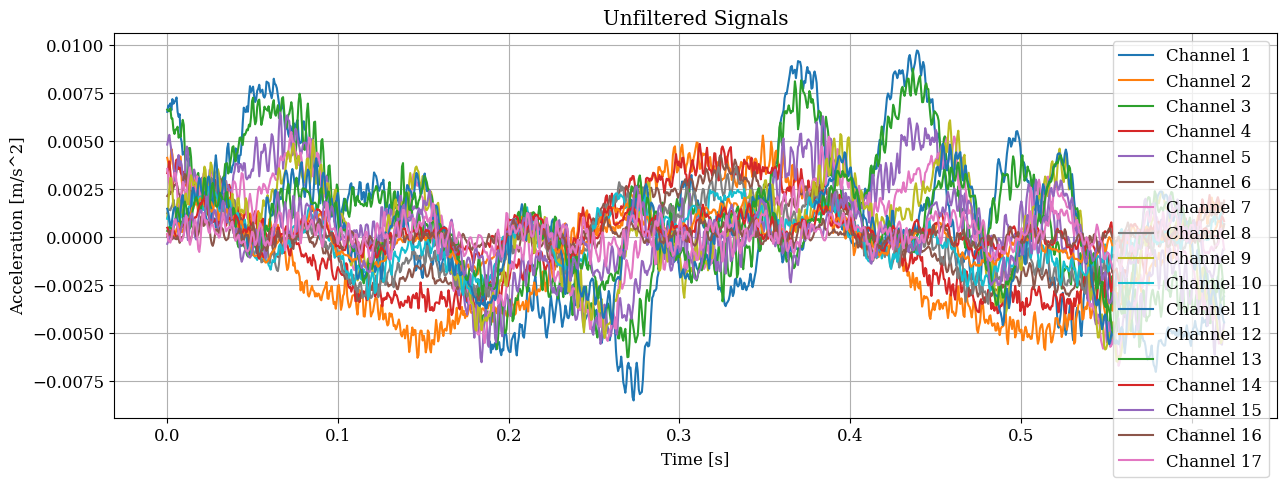

In [51]:
# Load data from an Excel file
# Assume the data is in the first sheet and starts in the first column

delta_t = 1/1651 # sampling interval [s]

df = df_data['data'].iloc[:,0:18]

f_time = delta_t * np.arange(1, (df.shape[0]+1))


x = df.to_numpy() # Convert DataFrame to numpy array

extracted_y = x[:,1:]
# Duration of the signal [s]
T = delta_t * (len(extracted_y))
Tmax = delta_t * (len(extracted_y) - 1)
delta_f = 1 / Tmax # sampling frequency [Hz]
t_qatar = np.arange(0, Tmax + delta_t, delta_t) # time array
# Plot unfiltered signals
plt.figure(figsize=(15, 5))
for i in range(extracted_y.shape[1]):
    plt.plot(t_qatar[0:1023], extracted_y[0:1023, i], label=f'Channel {i+1}')


plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.title('Unfiltered Signals')
plt.legend()
plt.grid()
plt.show()

# Preprocessing

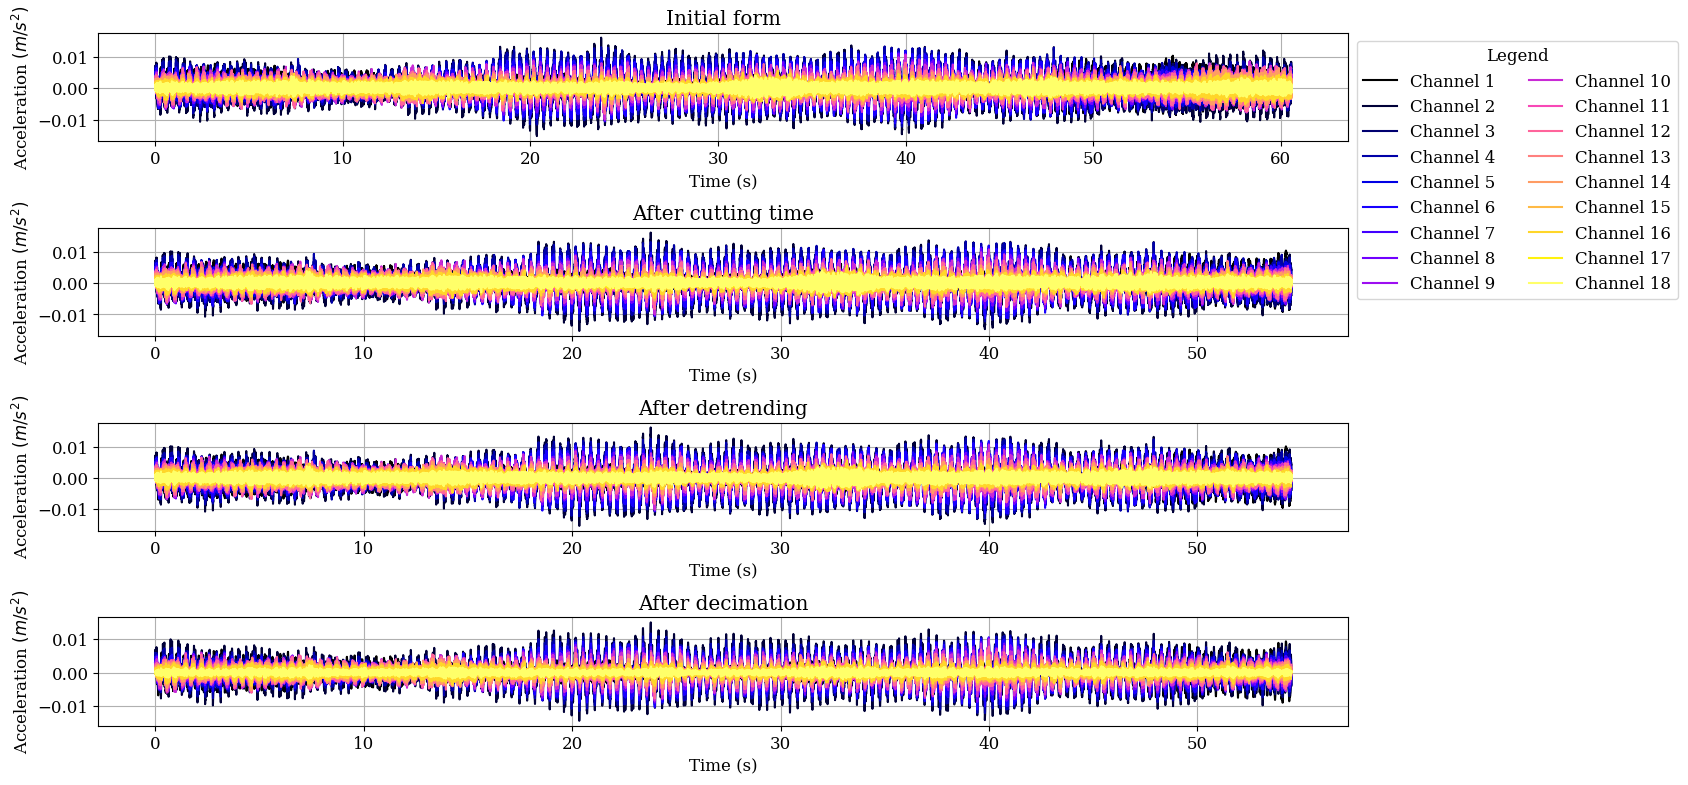

In [52]:
pp_sig, time_p = preprocess(df, f_time, do_detrend=True, do_sync=False, time_limit=[0, 0.9], channels_to_remove=[], decimate_downsample=7, filter_lim=0, filter_order=9)
dt = time_p[1] - time_p[0]

# FDD-EFDD on LUMO

## Part 1 (Getting SVD of PSD)

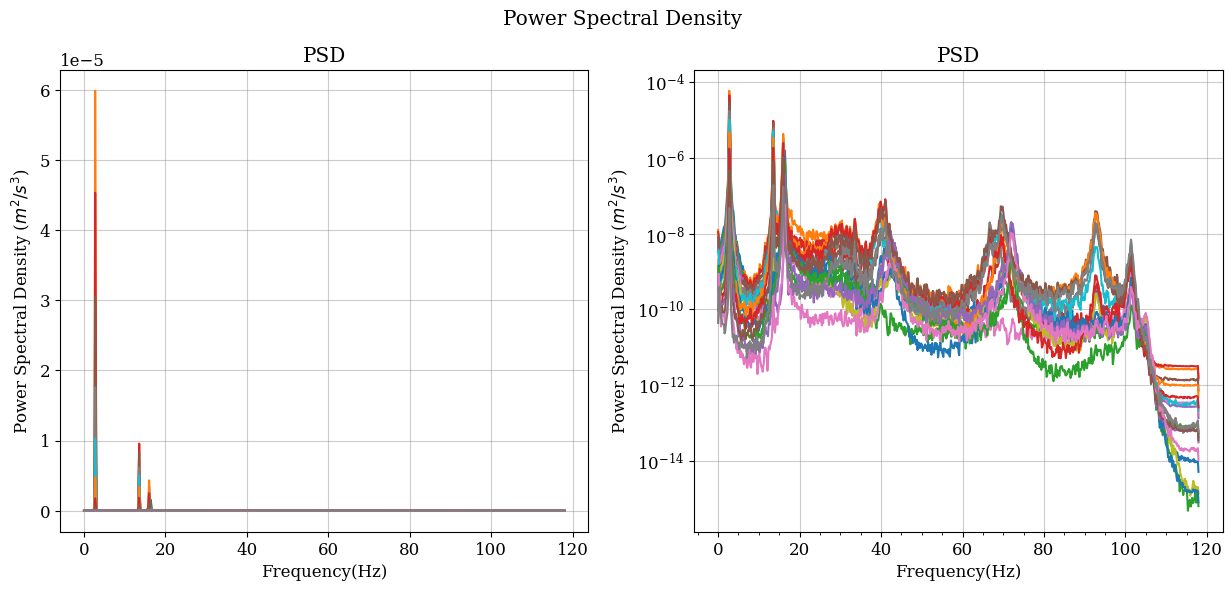

TypeError: svd_psd() missing 2 required positional arguments: 'nxseg' and 'num_chnl'

In [53]:
PSD_mat, f_psd, ss1, UU, t = FDD_SVD_Diagram(pp_sig, dt, window='hann', nseg=10 ,pov=0.5, show_semilog=True, )
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window

## Choosing frequencies

In [ ]:
## Natural Frequencies = [ [ ], [ ], [ ] ]
## Which n-th list in the main list contains frequencies read from the n-th singular value diagram

Natural_frequencies = [[2.7357, 13.534, 15.982], [2.88, 16.270]] ## Insert the Natural Frequencies Manually

## part 2 (Getting mode shapes)

c:\Users\Mehrab\Desktop\Code\OMA\Modalyzer\version 0.1.2\.venv-test\lib\site-packages\torch\_tensor.py:1228: ComplexWarning:

Casting complex values to real discards the imaginary part



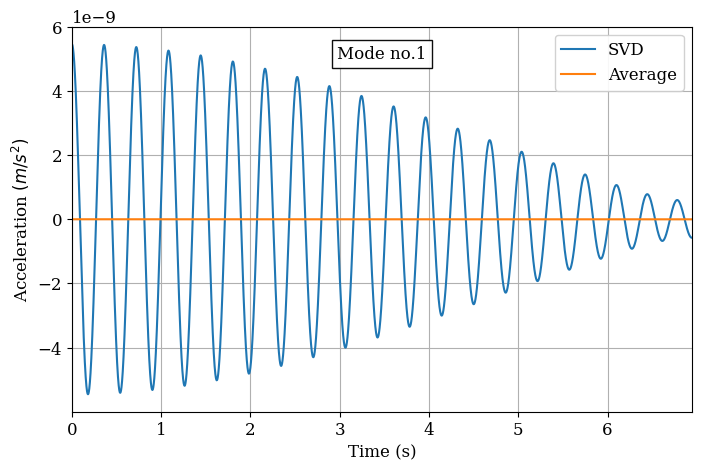

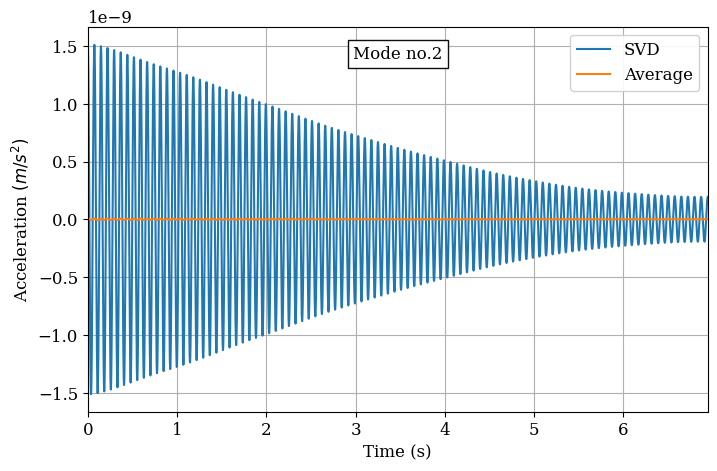

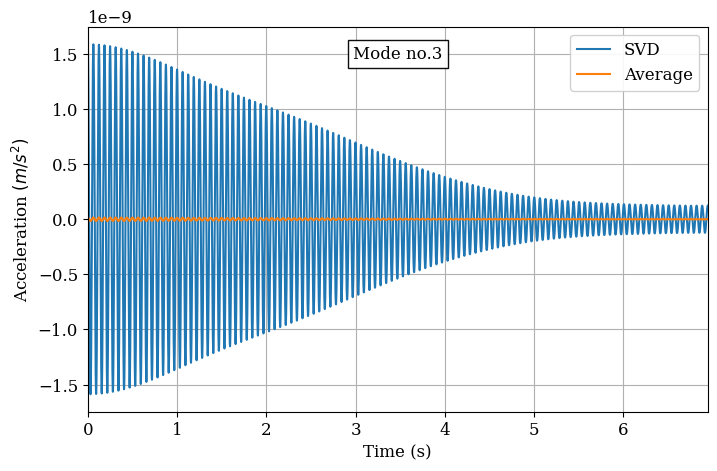

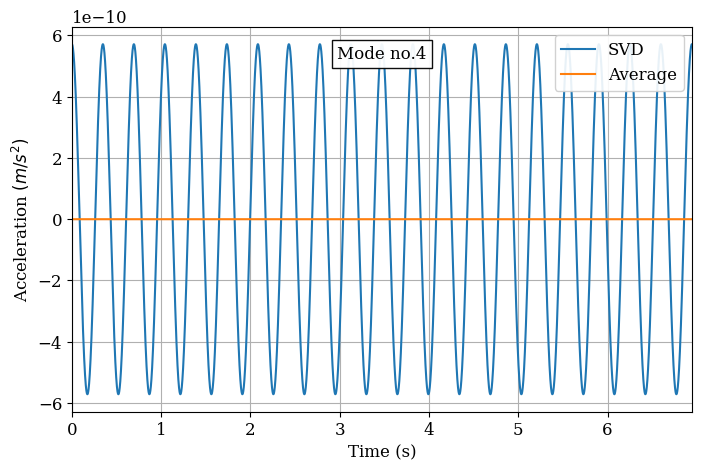

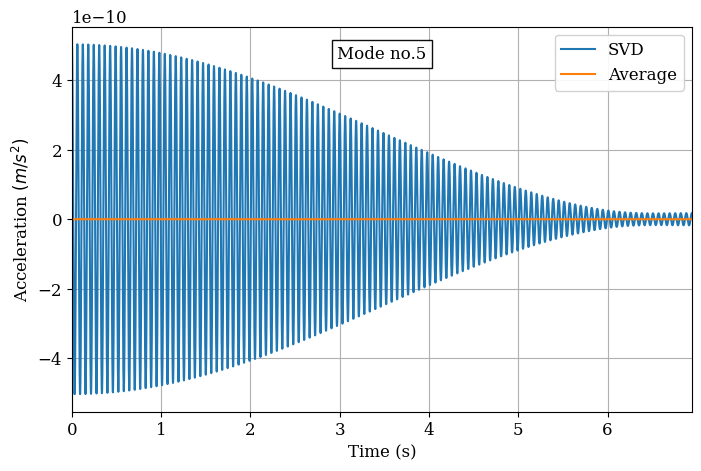

In [9]:
EFDD_Mode_shapes, SDOF, t_sdof = FDD_ModeShape(Natural_frequencies, PSD_mat, f_psd, ss1, UU, t,complex_mode_shape=True, MAC_Lim=0.90,plot_type='pyplot',show_mode_shape_number=True)

## Part 3 (Calculating damping ratios)

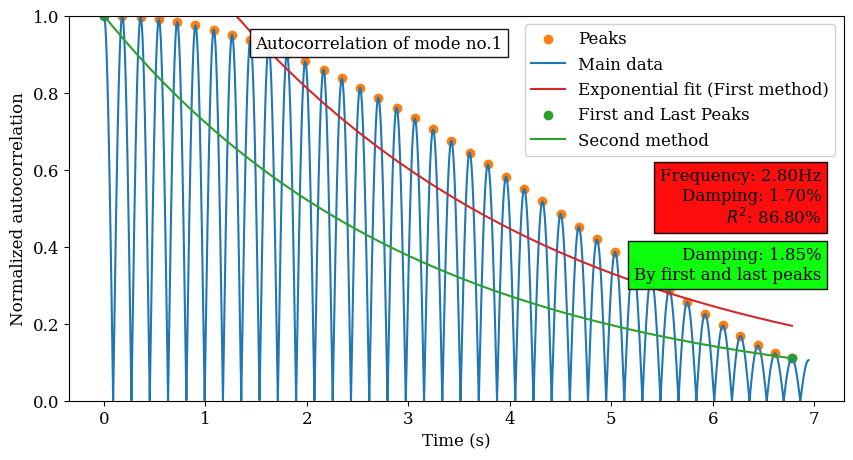

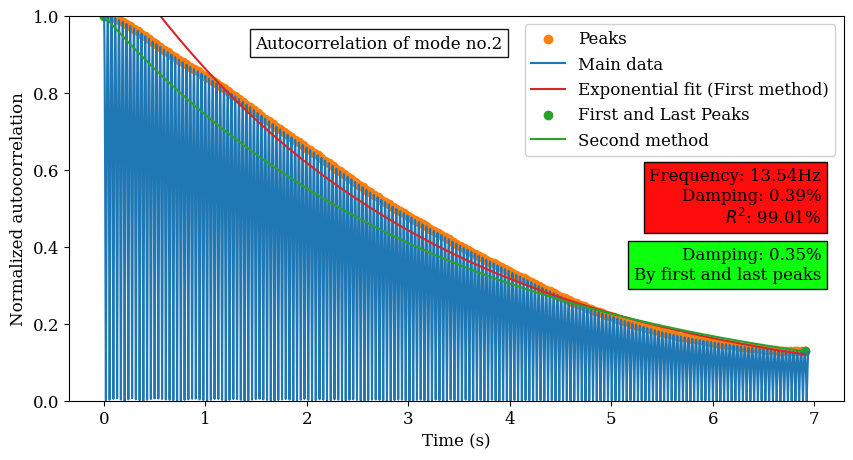

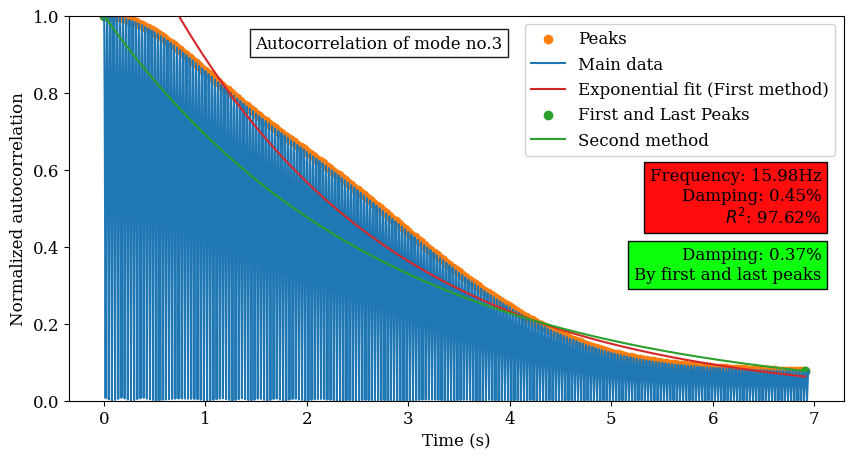

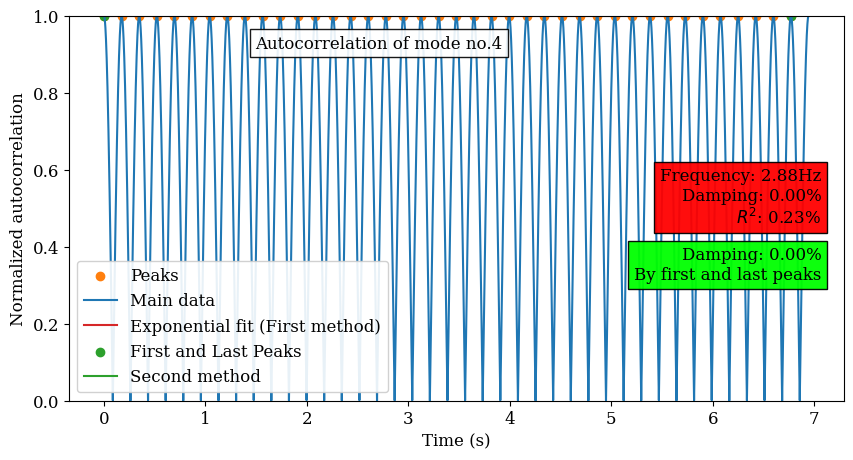

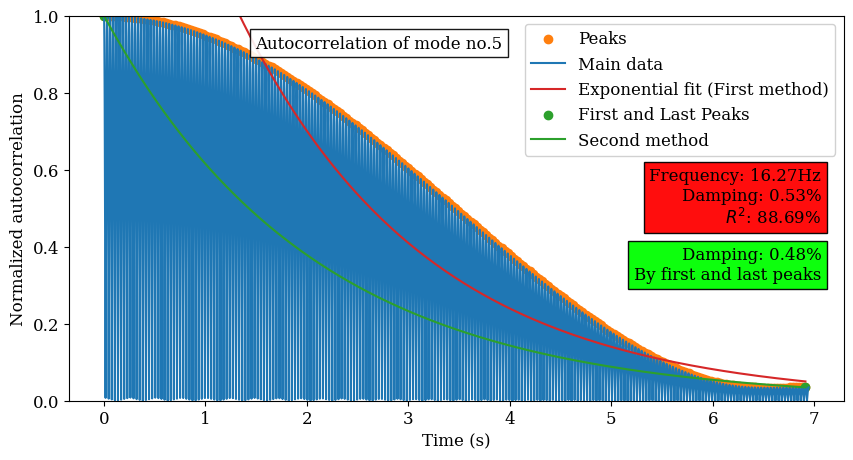

In [10]:
# With respect to SDOF autocorrelation diagrams, choose a time frame for modes
time_start = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
time_stop = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# PSD_method:
# 1. 'svd' for using first singular value of PSD for inverse Fourier transform.
# 2. 'avg' for using average of all channels PSDs.
EFDD_damps, EFDD_Natural_frequencies = FDD_Damping(SDOF, t_sdof, [time_start, time_stop], 'all_peaks', PSD_method='svd',show_mode_shape_number=True)

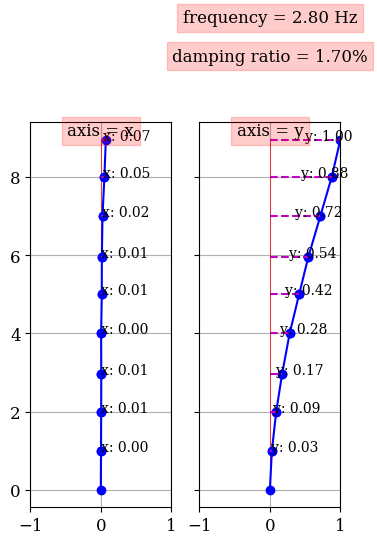

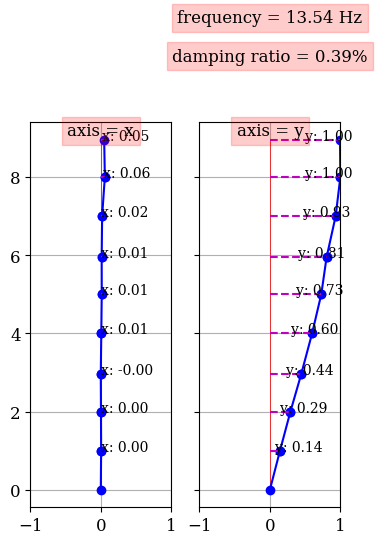

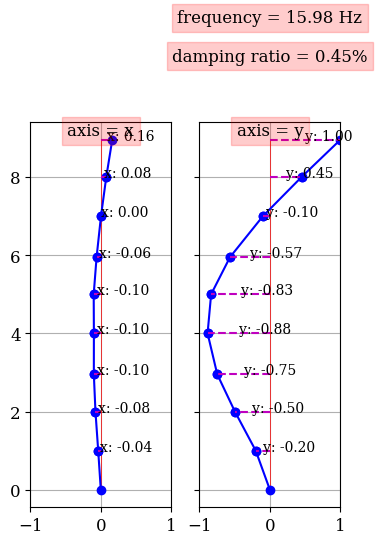

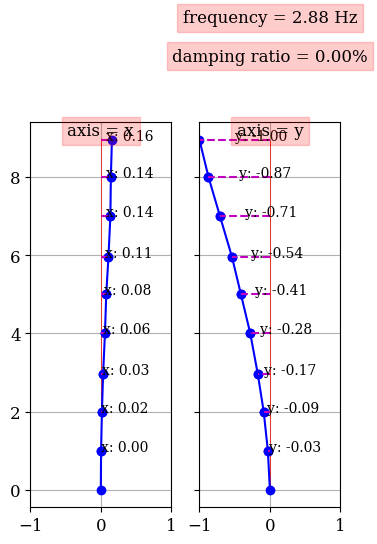

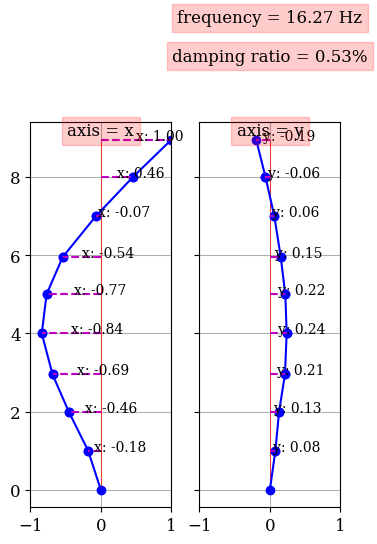

In [ ]:
freqs_to_show, damps_to_show, Mode_shapes_to_show = choose_modes(EFDD_Natural_frequencies,EFDD_damps, EFDD_Mode_shapes, mode_numbers=[])
coord_file_name = 'coords_lumo.csv'

draw_mode_shapes(coord_file_name, list_mode_shapes=Mode_shapes_to_show, list_freqs=freqs_to_show, list_damps=damps_to_show, base_axis='z', base_axis_align='vertical',write_modal_info=True)

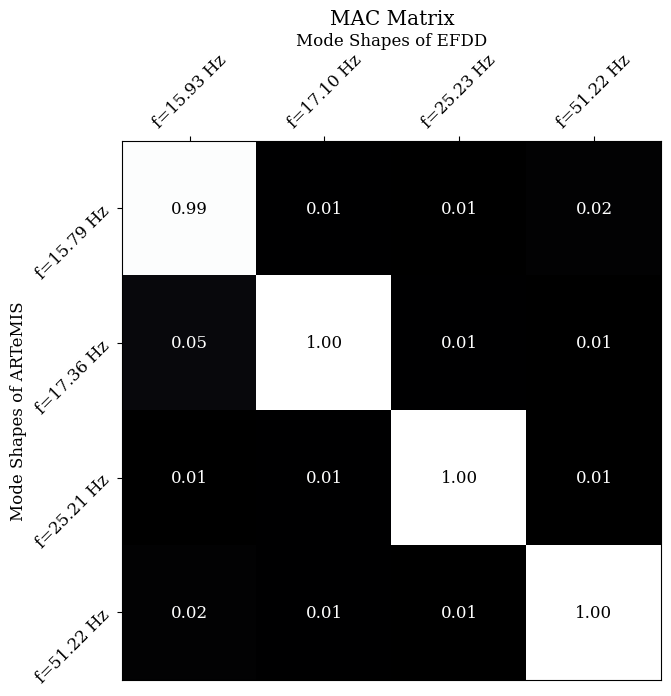

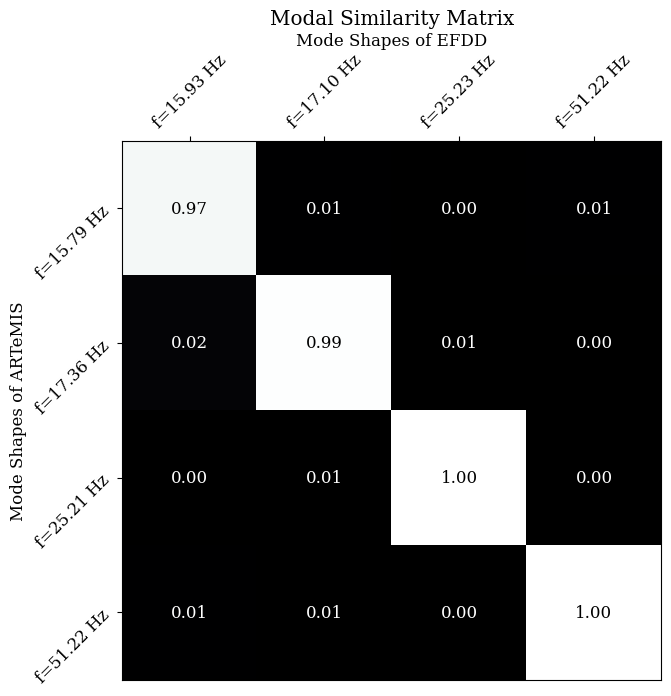

In [ ]:
draw_MAC_diagram(efdd_shape_sorted, artemis_shape, EFDD_frequencies_sorted, artemis_freq, labels=('EFDD', 'ARTeMIS'))
draw_MAC_diagram(efdd_shape_sorted, artemis_shape, EFDD_frequencies_sorted, artemis_freq, labels=('EFDD', 'ARTeMIS'), modal_similarity_criterion=True)

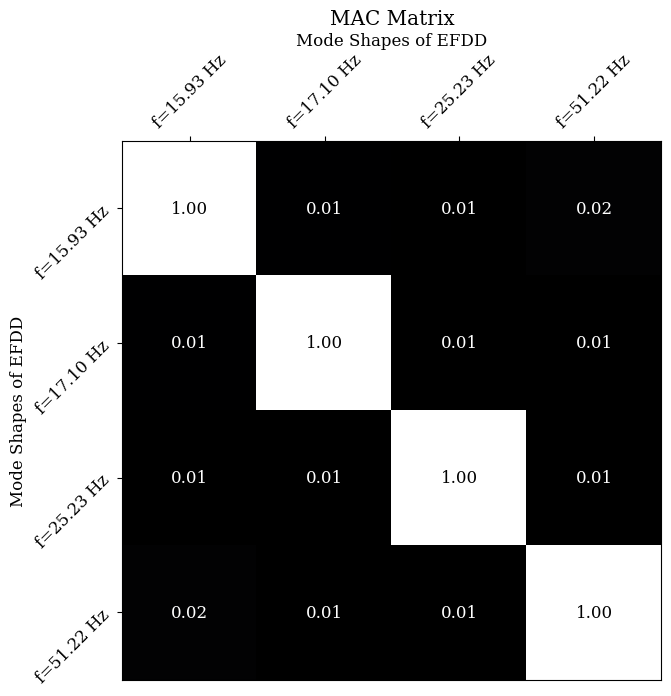

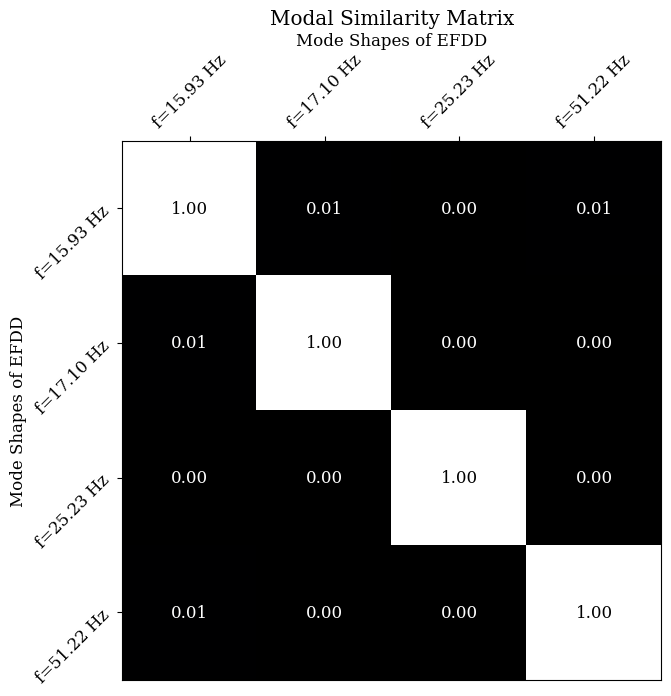

In [ ]:
# EFDD_freqs_30 = []
# for i in range(len(EFDD_Natural_frequencies)):
#     EFDD_freqs_30.append(EFDD_Natural_frequencies[i].reshape(-1))
# # ssi_msh_30 = []
# for i in range(len(Mode_shapes_to_show)):
#     ssi_msh_30.append(Mode_shapes_to_show[i].reshape(-1))
draw_MAC_diagram(efdd_shape_sorted, efdd_shape_sorted, EFDD_frequencies_sorted, EFDD_frequencies_sorted, ('EFDD', 'EFDD'), '2D')
draw_MAC_diagram(efdd_shape_sorted, efdd_shape_sorted, EFDD_frequencies_sorted, EFDD_frequencies_sorted, ('EFDD', 'EFDD'), '2D', modal_similarity=True)

In [13]:
results_table(EFDD_Natural_frequencies, EFDD_damps)

Frequencies  Damping Ratios
0     2.802591    1.696384e-02
1    13.535104    3.921481e-03
2    15.982822    4.464108e-03
3     2.879751    4.381786e-10
4    16.271781    5.251058e-03

# SSI on LUMO

## SSI-COV

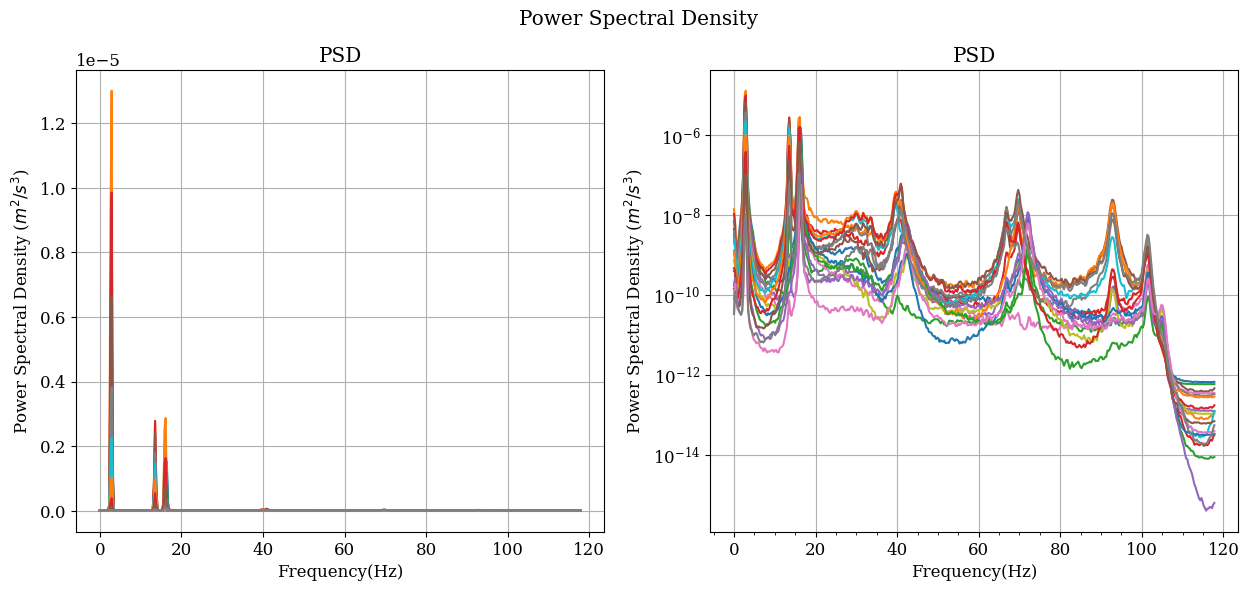

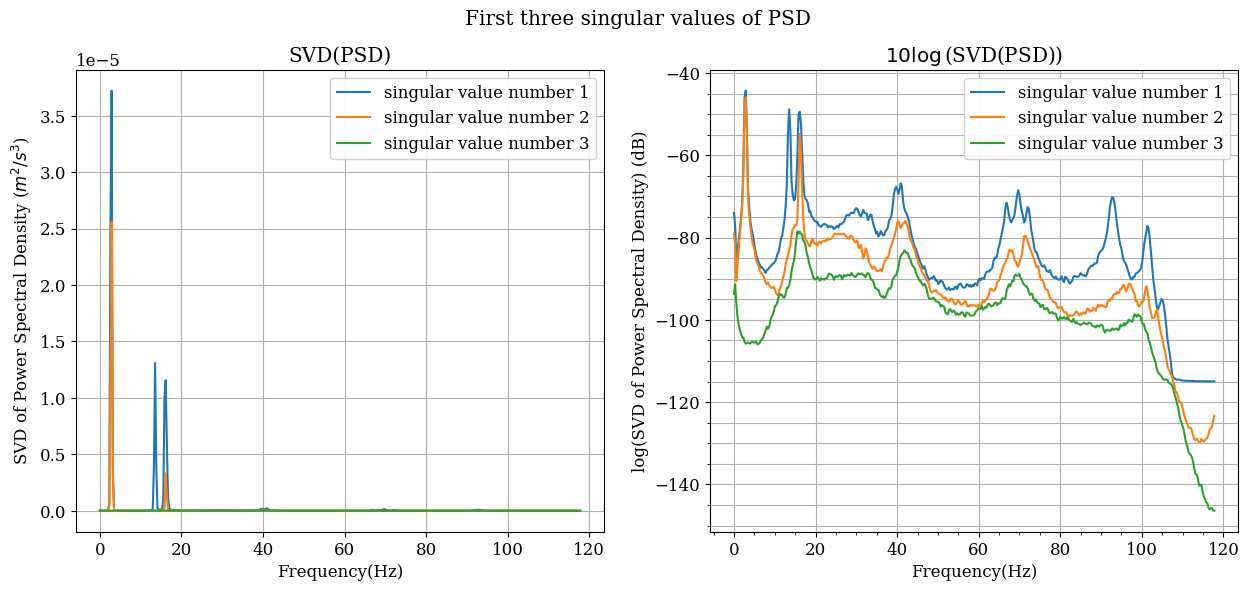

In [15]:
PSD_mat, f_psd = psd_func(pp_sig, dt,show_semilog=True, nseg=80 ,pov=0.8)
ss1, UU = svd_psd(PSD_mat, f_psd, show_semilog=False)

### SSI_COV (CVA)

In [29]:
################################## uncomment the method you want
alg = 'cva'
method = 1
lag = 25 # i
order = 60 # n
# cov:  l*i > n
# l = number of sensors

SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, SSI_Stable_phis = SSI_Alg(pp_sig,order,lag,dt,criteria = [0.008, 0.05, 0.02],alg=alg,method=method,Num_poles_to_accept_a_mode=5)
print(SSI_Stable_frequencies)
print(SSI_Stable_zetas)
# print(SSI_Stable_phis)

[tensor(2.7747), tensor(2.8174), tensor(13.5383), tensor(16.0090), tensor(16.3346), tensor(30.9444), tensor(31.1087), tensor(39.6466), tensor(40.9404), tensor(42.4977), tensor(66.8394), tensor(69.7094), tensor(72.1171), tensor(92.8424), tensor(101.3913), tensor(102.9575)]
[tensor(0.0013), tensor(0.0079), tensor(0.0027), tensor(0.0029), tensor(0.0041), tensor(0.0799), tensor(0.0831), tensor(0.0165), tensor(0.0156), tensor(0.0201), tensor(0.0095), tensor(0.0088), tensor(0.0062), tensor(0.0052), tensor(0.0035), tensor(0.0130)]


In [ ]:
stabilization_diagram(SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, xlim=0, ylim=[0,order], add_PSD_SVD=True, show_second_singular_value=True, f_psd=f_psd, ss1=np.log10(ss1), without_mode_shape=False)


In [32]:
results_table(SSI_Stable_frequencies, SSI_Stable_zetas)

Frequencies  Damping Ratios
0      2.774654        0.001285
1      2.817420        0.007879
2     13.538268        0.002692
3     16.009031        0.002887
4     16.334591        0.004052
5     30.944433        0.079912
6     31.108709        0.083085
7     39.646622        0.016531
8     40.940449        0.015559
9     42.497658        0.020061
10    66.839386        0.009463
11    69.709435        0.008792
12    72.117134        0.006238
13    92.842354        0.005190
14   101.391350        0.003506
15   102.957458        0.012967

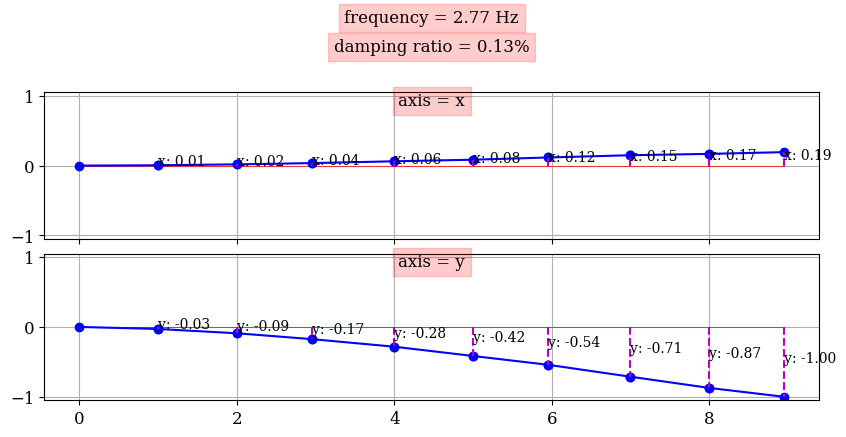

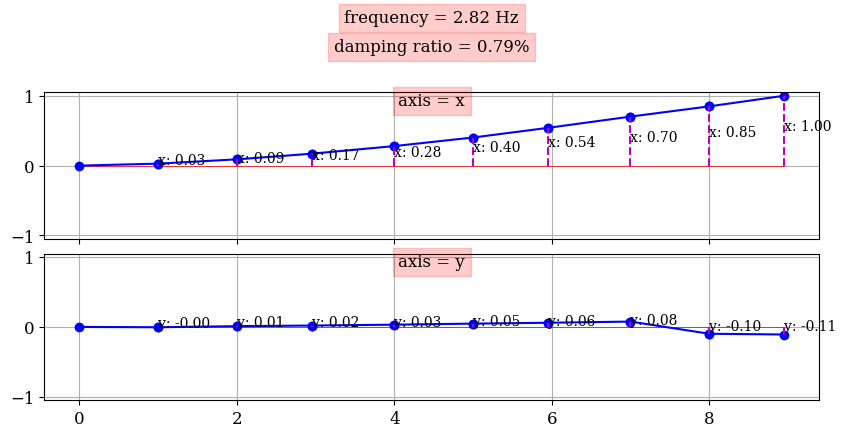

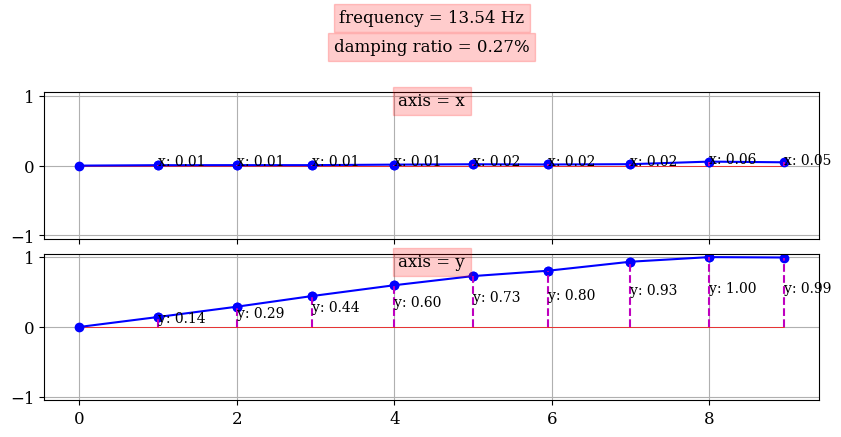

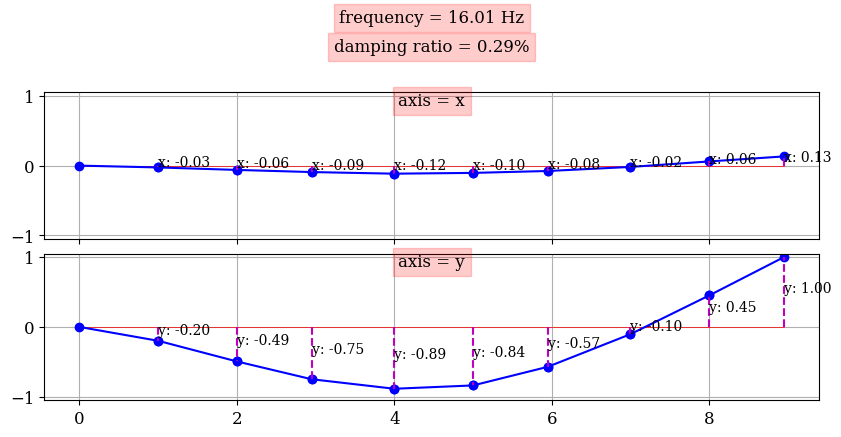

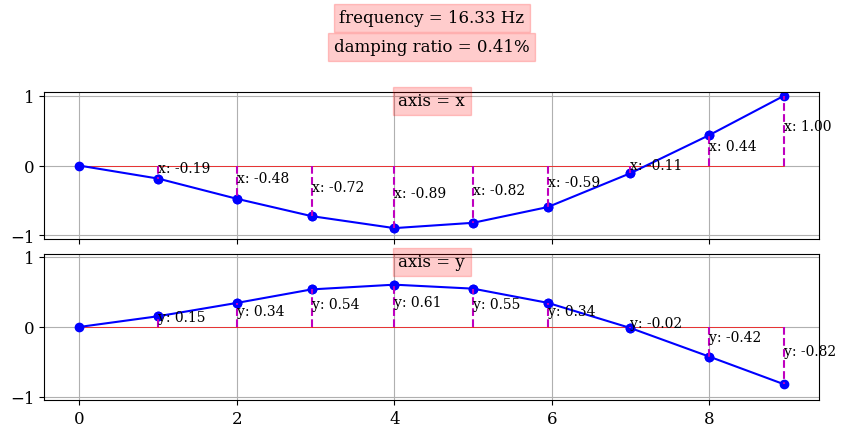

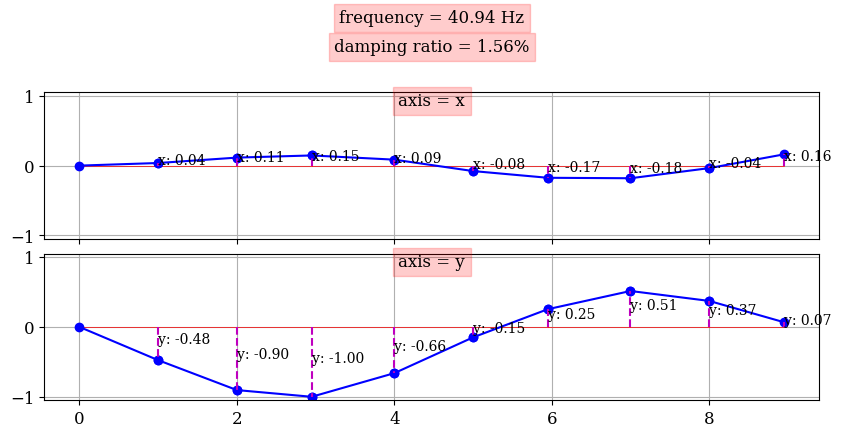

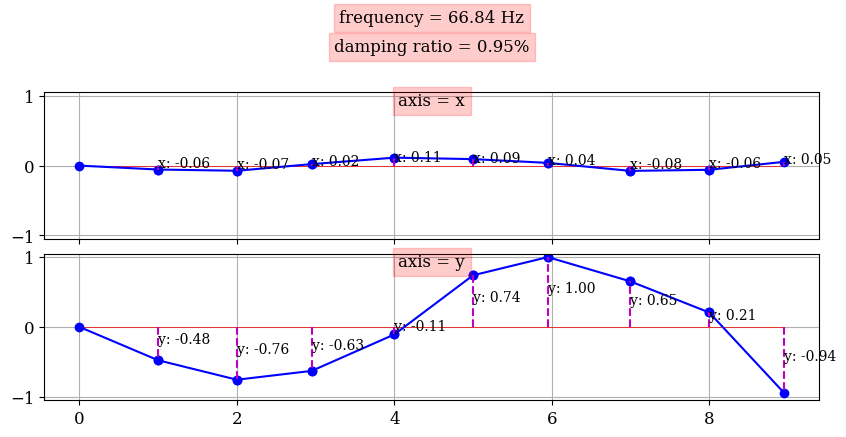

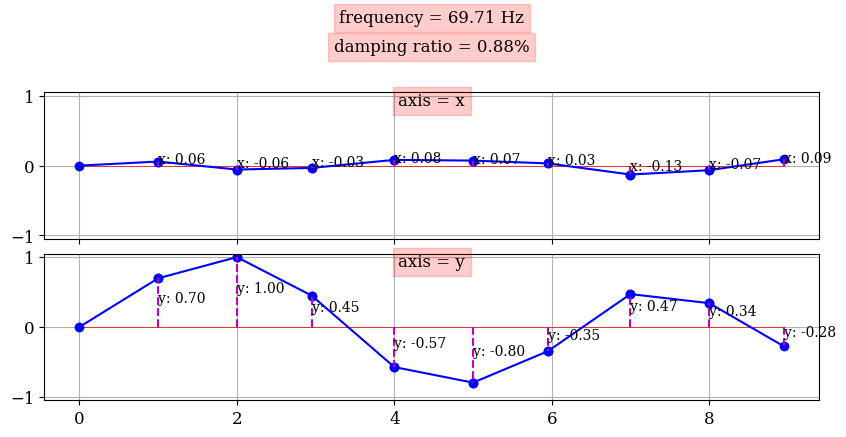

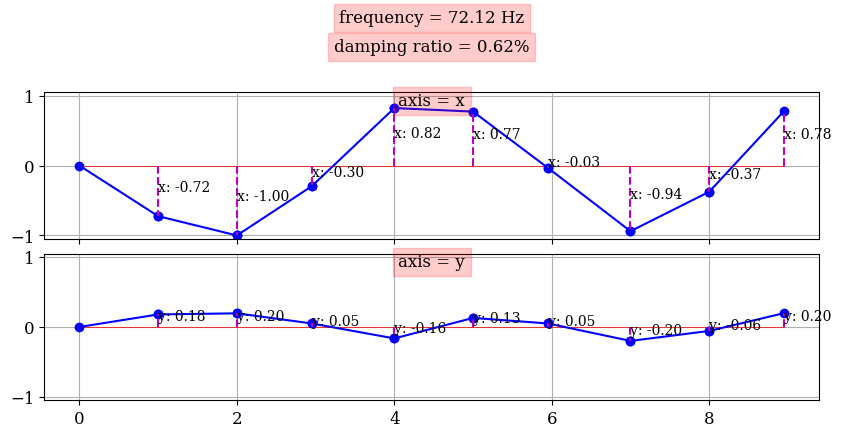

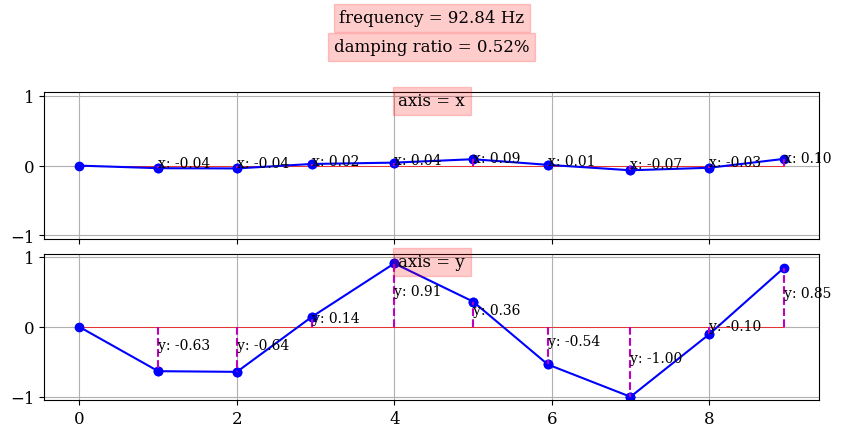

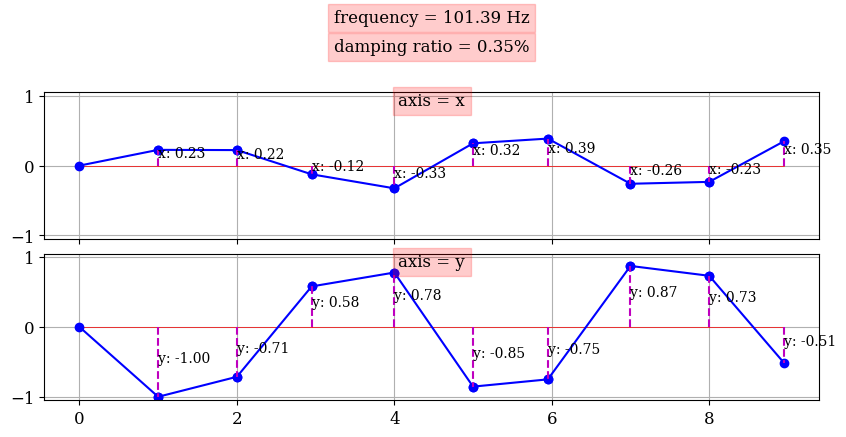

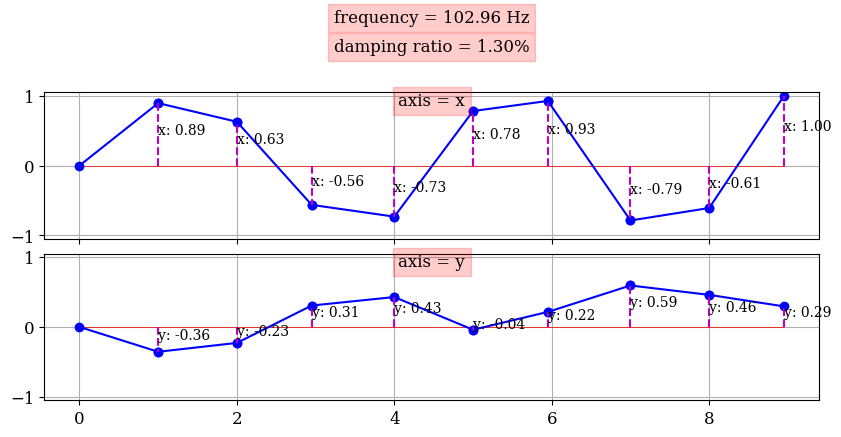

In [ ]:
freqs_ssi_to_show, damps_ssi_to_show, mode_shapes_ssi_to_show = choose_modes(SSI_Stable_frequencies, SSI_Stable_zetas, SSI_Stable_phis, mode_numbers=[0,1,2,3,4,8,10,11,12,13,14,15])


file_csv = 'coords_lumo.csv'
draw_mode_shapes(file_csv, mode_shapes_ssi_to_show, list_freqs=freqs_ssi_to_show, list_damps=damps_ssi_to_show, write_modal_info=True)

### SSI-COV (BR)

In [ ]:
################################## uncomment the method you want
alg = 'cov'
uncertainty = False
method = 1
lag = 15 # i
order = 40 # n
# cov:  l*i > n
# l = number of sensors

SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, SSI_Stable_phis = SSI_Alg(
    pp_sig,order,lag,dt,criteria = [0.01, 0.05, 0.02], 
    alg=alg,method=method,Num_poles_to_accept_a_mode=5,
    uncertainty=uncertainty)
print(SSI_Stable_frequencies)
print(SSI_Stable_zetas)
# print(SSI_Stable_phis)

[tensor(2.8220), tensor(15.9858), tensor(16.3347), tensor(30.8281), tensor(40.0371), tensor(41.0491), tensor(42.5654), tensor(66.8536), tensor(69.6168), tensor(72.1271), tensor(92.9214), tensor(101.3891)]
[tensor(0.0027), tensor(0.0020), tensor(0.0024), tensor(0.0930), tensor(0.0145), tensor(0.0163), tensor(0.0172), tensor(0.0084), tensor(0.0089), tensor(0.0063), tensor(0.0050), tensor(0.0060)]


c:\Users\Mehrab\Desktop\Code\OMA\Modalyzer\version 0.1.2\.venv-test\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\Users\Mehrab\Desktop\Code\OMA\Modalyzer\version 0.1.2\.venv-test\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning:

Casting complex values to real discards the imaginary part



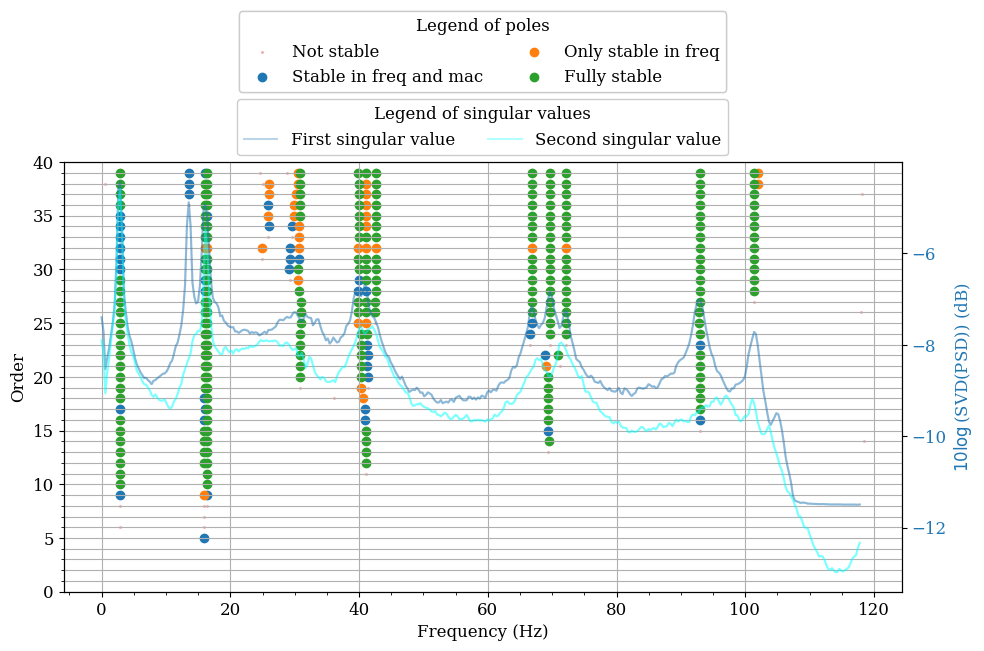

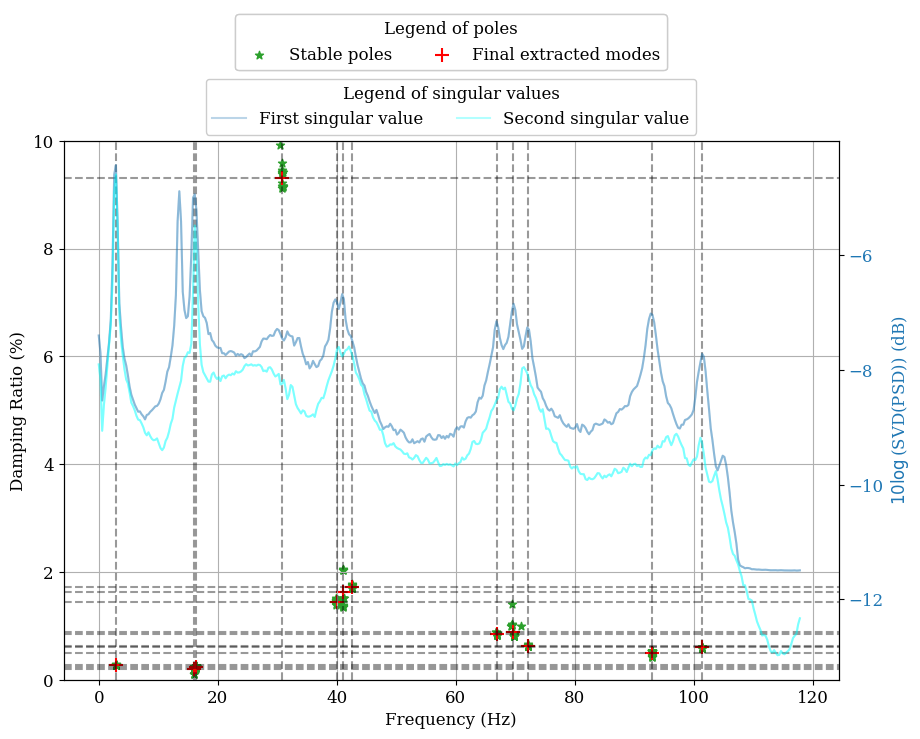

In [36]:
stabilization_diagram(SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, xlim=0, ylim=[0,order], add_PSD_SVD=True, show_second_singular_value=True, f_psd=f_psd, ss1=np.log10(ss1), without_mode_shape=False)

In [37]:
results_table(SSI_Stable_frequencies,SSI_Stable_zetas)

Frequencies  Damping Ratios
0      2.821970        0.002740
1     15.985848        0.002014
2     16.334688        0.002416
3     30.828135        0.093008
4     40.037071        0.014493
5     41.049076        0.016271
6     42.565414        0.017211
7     66.853600        0.008437
8     69.616806        0.008907
9     72.127068        0.006269
10    92.921364        0.005026
11   101.389061        0.005982

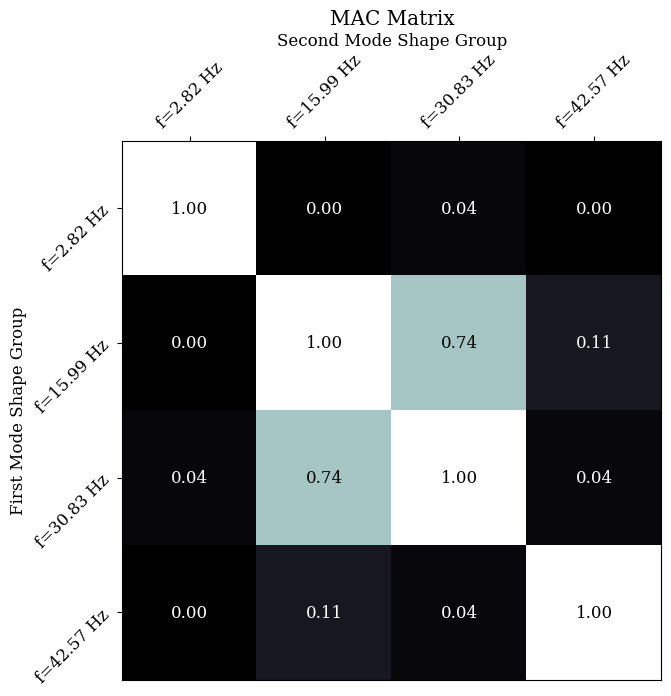

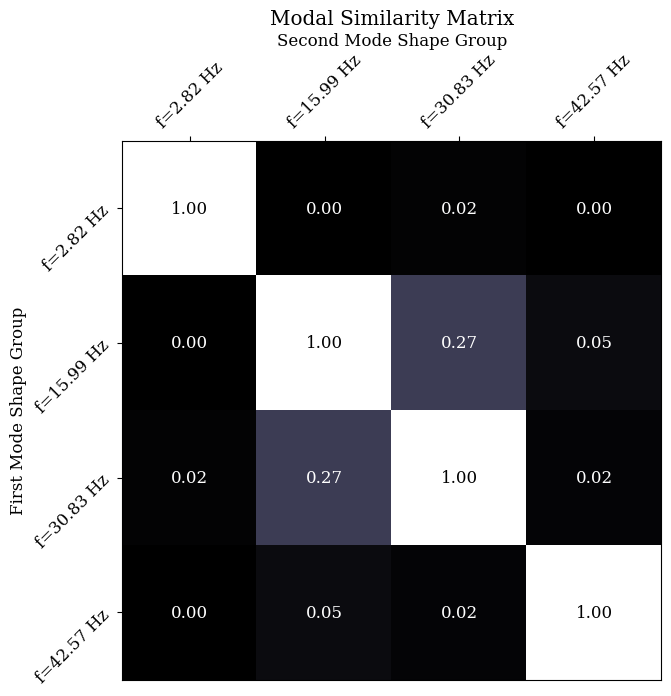

In [39]:
freqs_to_show, damps_to_show, Mode_shapes_to_show = choose_modes(SSI_Stable_frequencies, SSI_Stable_zetas, SSI_Stable_phis, mode_numbers=[0,1,3,6])
# coord_file_name = 'coords_qatar.csv'
draw_MAC_diagram(Mode_shapes_to_show, Mode_shapes_to_show, freqs_to_show, freqs_to_show, ('SSI-COV', 'SSI-COV'), '2D')
draw_MAC_diagram(Mode_shapes_to_show, Mode_shapes_to_show, freqs_to_show, freqs_to_show, ('SSI-COV', 'SSI-COV'), '2D', modal_similarity_criterion=True)
# draw_mode_shapes(coord_file_name, list_mode_shapes=Mode_shapes_to_show, list_freqs=freqs_to_show, list_damps=damps_to_show, base_axis='x', base_axis_align='horizontal')

In [ ]:
artemis_data = pd.read_csv('qatar_mode_shapes.csv',header=None)
artemis_freq = np.array(artemis_data.iloc[0,:])
artemis_mode = np.array(artemis_data.iloc[1:,:])
artemis_shape = []
ssicov_shape = []
for i in range(artemis_mode.shape[1]):
    artemis_shape.append(artemis_mode[:,i].reshape(-1))
    ssicov_shape.append(Mode_shapes_to_show[i].reshape(-1))

artemis_freq

array([15.786, 17.357, 25.214, 51.215])

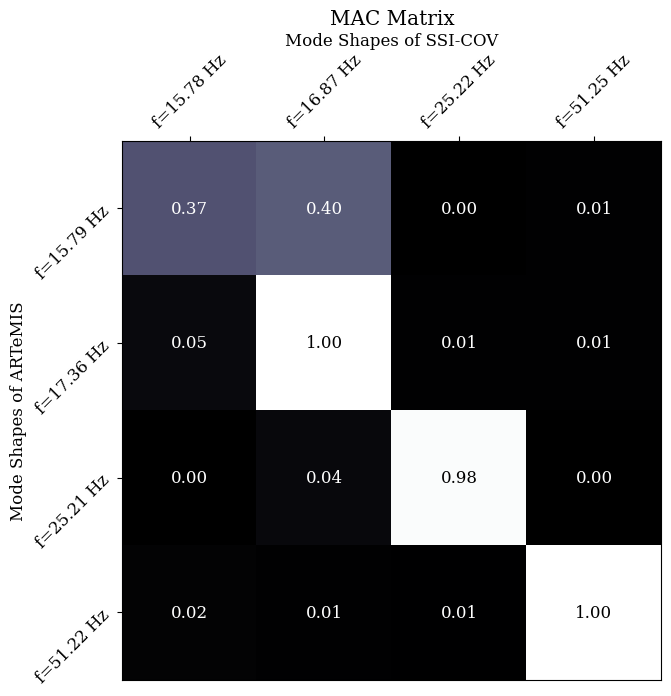

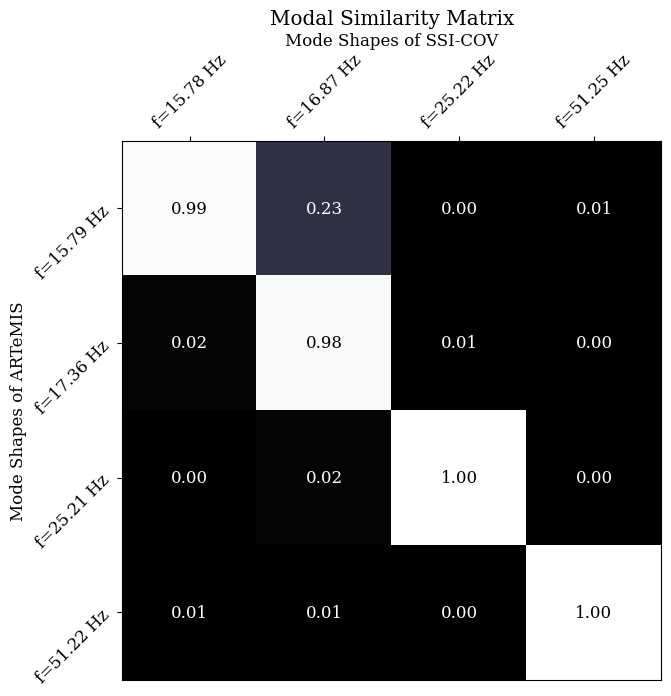

In [ ]:
draw_MAC_diagram(ssicov_shape, artemis_shape, freqs_to_show, artemis_freq, labels=('SSI-COV', 'ARTeMIS'))
draw_MAC_diagram(ssicov_shape, artemis_shape, freqs_to_show, artemis_freq, labels=('SSI-COV', 'ARTeMIS'), modal_similarity=True)

In [ ]:
Mode_shapes[0]

tensor([ 0.6079,  0.8989,  1.0000,  0.9225,  0.6829,  0.3044,  0.5319,  0.6229,
         0.5371,  0.3038,  0.1757,  0.3031,  0.3474,  0.2856,  0.1449,  0.1423,
         0.1976,  0.2142,  0.1884, -0.1389, -0.1490, -0.2248, -0.2566, -0.2302,
        -0.1617, -0.1708, -0.2867, -0.3408, -0.2910, -0.1765])

### SSI-COV (UNC)

In [ ]:
################################## uncomment the method you want
alg = 'cov'
uncertainty = True
nb = 50
method = 1
lag = 15 # i
order = 60 # n
unc_criteria = []
# cov:  l*i > n
# l = number of sensors

SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, SSI_Stable_phis = ssi_alg2(
    pp_sig,order=order,lag=lag,dt=dt,criteria = [0.02, 0.03, 0.02], 
    alg=alg,method=method,Num_poles_to_accept_a_mode=2,nb=nb,
    uncertainty=uncertainty, unc_criteria=unc_criteria)
print(SSI_Stable_frequencies)
print(SSI_Stable_zetas)
# print(SSI_Stable_phis)

Computing Qmax pack ... (27/270), time = 0.85s
Computing Qmax pack ... (54/270), time = 0.83s
Computing Qmax pack ... (81/270), time = 1.01s
Computing Qmax pack ... (108/270), time = 0.96s
Computing Qmax pack ... (135/270), time = 0.87s
Computing Qmax pack ... (162/270), time = 0.84s
Computing Qmax pack ... (189/270), time = 0.85s
Computing Qmax pack ... (216/270), time = 0.81s
Computing Qmax pack ... (243/270), time = 0.81s
Computing Qmax pack ... (270/270), time = 0.90s
Computing order: 6/60
Computing order: 12/60
Computing order: 18/60
Computing order: 24/60
Computing order: 30/60
Computing order: 36/60
Computing order: 42/60
Computing order: 48/60
Computing order: 54/60
Computing order: 60/60
#######################
[tensor(2.8217), tensor(13.5457), tensor(15.9868), tensor(16.3343), tensor(30.8298), tensor(40.5236), tensor(42.5593), tensor(48.0125), tensor(66.8376), tensor(69.6646), tensor(72.1292), tensor(92.9092), tensor(101.4421)]
[tensor(0.0027), tensor(0.0005), tensor(0.0021),

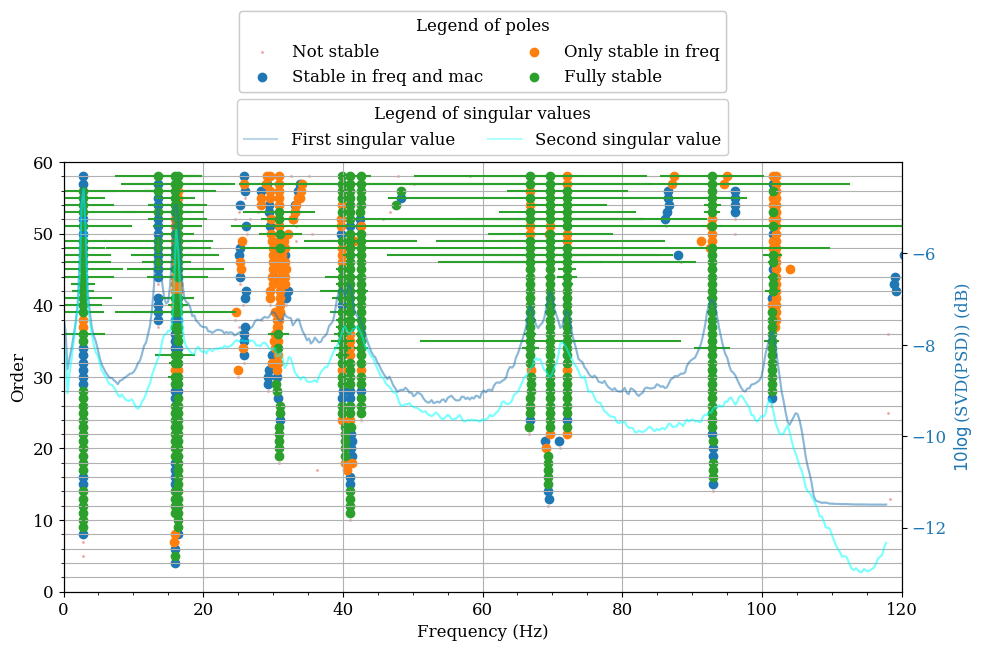

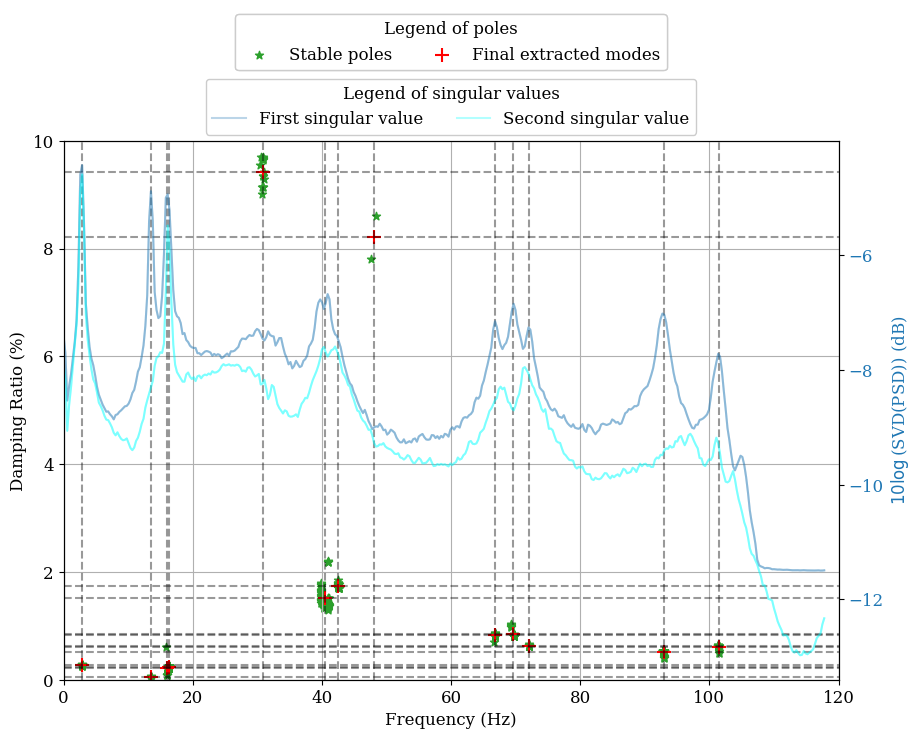

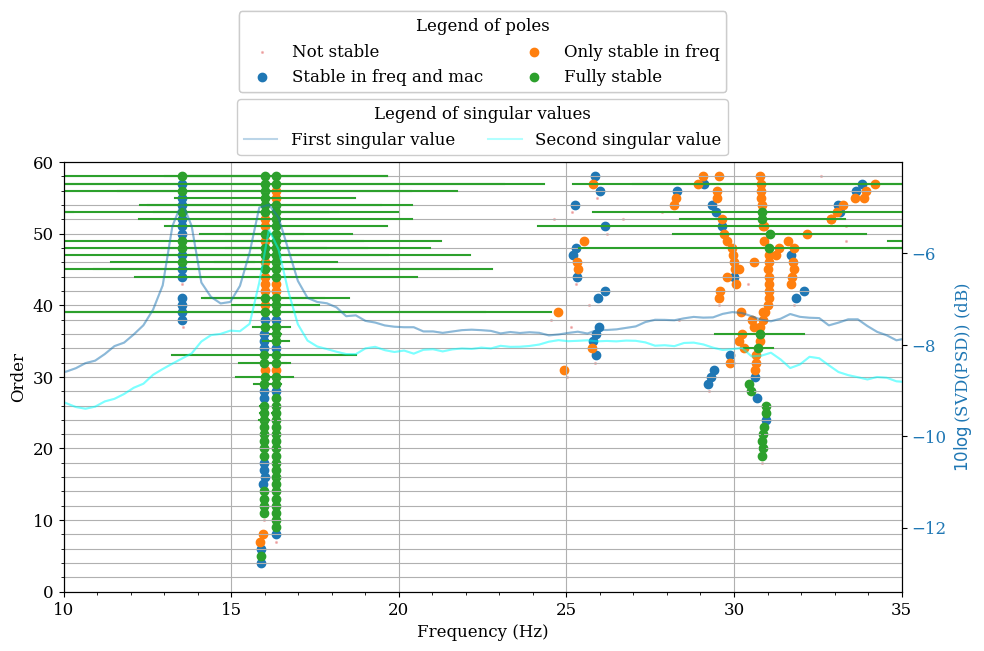

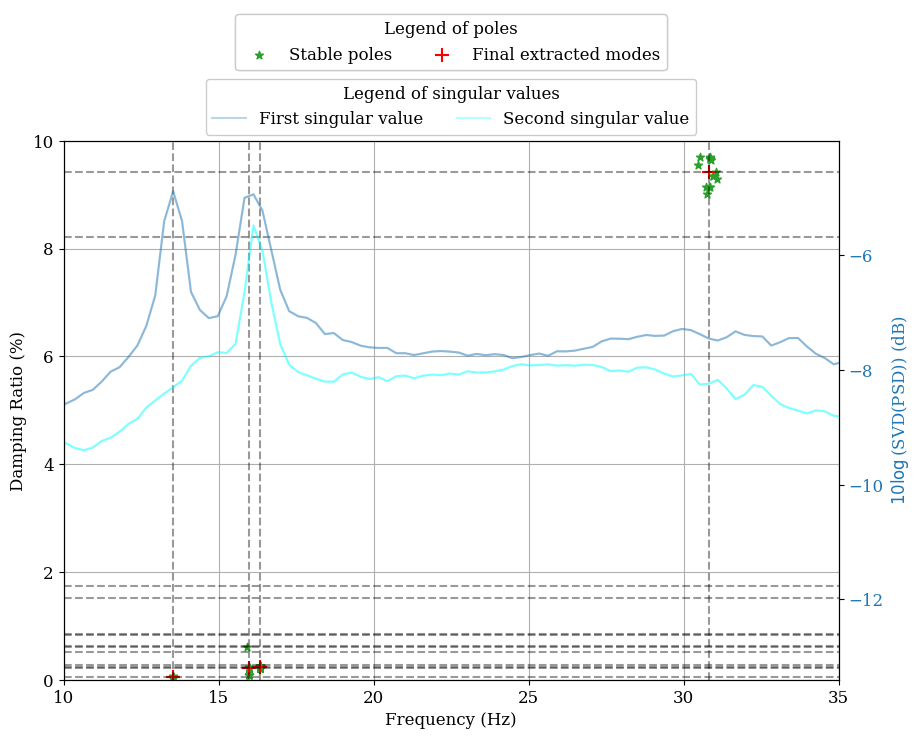

In [ ]:
# from SSI_func import SSI_Alg, psd_func, svd_psd, stabilization_diagram
stabilization_diagram(SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, 
                      xlim=[0,120], ylim=[0,order], add_PSD_SVD=True, show_second_singular_value=True, 
                      f_psd=f_psd, ss1=np.log10(ss1), without_mode_shape=False, draw_unc=True, scale_unc=0.1)

stabilization_diagram(SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, 
                      xlim=[10,35], ylim=[0,order], add_PSD_SVD=True, show_second_singular_value=True, 
                      f_psd=f_psd, ss1=np.log10(ss1), without_mode_shape=False, draw_unc=True, scale_unc=0.1)

In [72]:
results_table(SSI_Stable_frequencies, SSI_Stable_zetas)

Frequencies  Damping Ratios
0      2.821660        0.002703
1     13.545697        0.000471
2     15.986811        0.002097
3     16.334288        0.002346
4     30.829842        0.094259
5     40.523643        0.015168
6     42.559307        0.017363
7     48.012520        0.082089
8     66.837555        0.008205
9     69.664619        0.008424
10    72.129234        0.006314
11    92.909248        0.005171
12   101.442123        0.006037

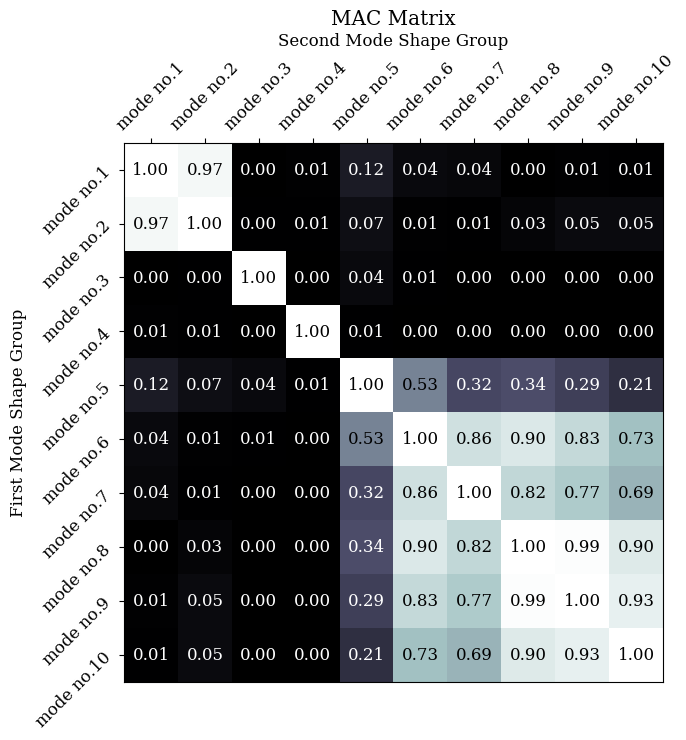

In [43]:
draw_MAC_diagram(SSI_Stable_phis,SSI_Stable_phis)

## SSI-Data

In [90]:
################################## uncomment the method you want
pp_sig_ssidata = pp_sig[:5000,:]


alg = 'data'
method = 0
lag = 40 # Number of Block Rows for DATA Alg
order = 50
# data: Number of Block Rows > order

SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, SSI_Stable_phis = SSI_Alg(pp_sig_ssidata,order,lag,dt,criteria = [0.01, 0.05, 0.02],alg=alg,method=method,Num_poles_to_accept_a_mode=6)
print(SSI_Stable_frequencies)
print(SSI_Stable_zetas)
# print(Stable_phis)

[tensor(2.8268), tensor(13.5490), tensor(15.9959), tensor(16.3483), tensor(39.8075), tensor(41.0208), tensor(42.6370), tensor(66.9951), tensor(69.8066), tensor(72.1691), tensor(92.9071), tensor(101.1040)]
[tensor(0.0071), tensor(0.0016), tensor(0.0019), tensor(0.0025), tensor(0.0123), tensor(0.0147), tensor(0.0116), tensor(0.0069), tensor(0.0064), tensor(0.0045), tensor(0.0039), tensor(0.0030)]


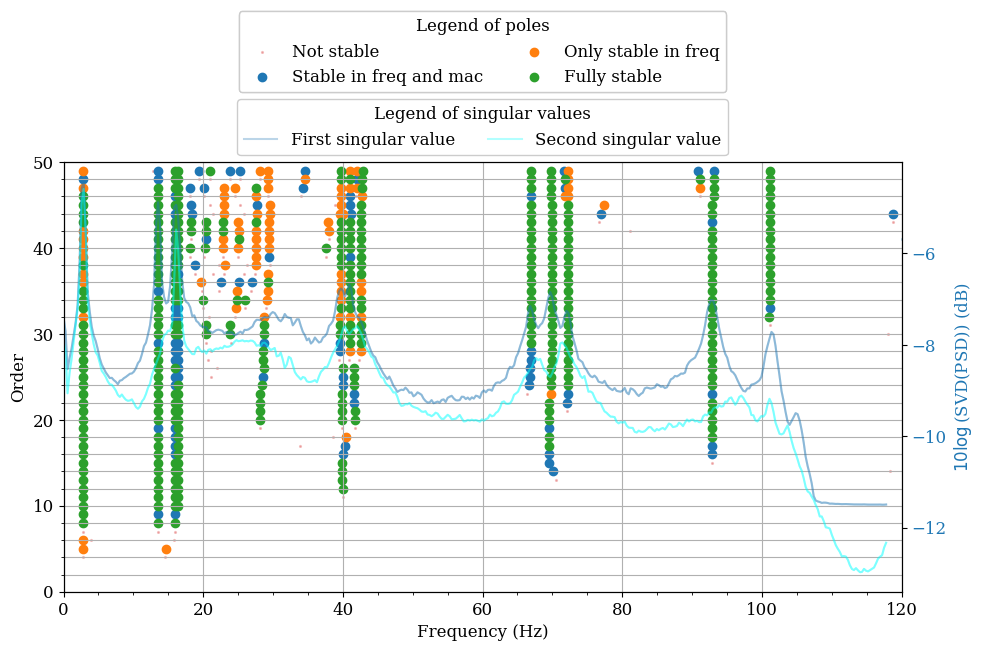

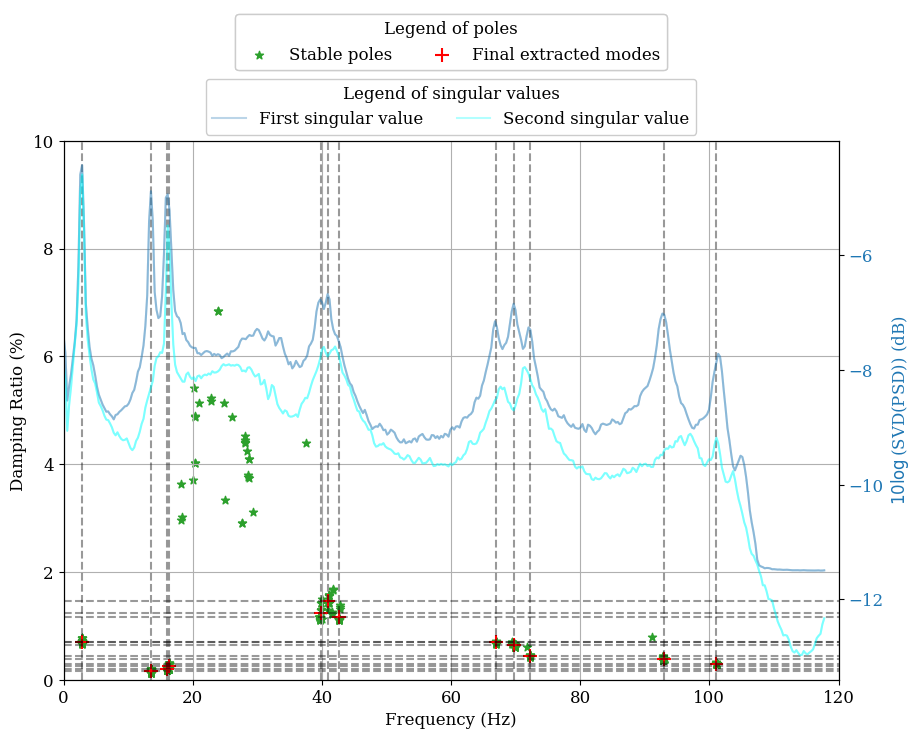

In [92]:
stabilization_diagram(SSI_Coord_dict, SSI_Stable_frequencies, SSI_Stable_zetas, xlim=[0,120], ylim=[0,order], add_PSD_SVD=True, f_psd=f_psd, ss1=np.log10(ss1), show_second_singular_value=True)

In [93]:
results_table(SSI_Stable_frequencies,SSI_Stable_zetas)

Frequencies  Damping Ratios
0      2.826805        0.007051
1     13.548981        0.001618
2     15.995924        0.001921
3     16.348284        0.002455
4     39.807537        0.012286
5     41.020802        0.014659
6     42.636982        0.011625
7     66.995117        0.006908
8     69.806564        0.006368
9     72.169106        0.004453
10    92.907097        0.003883
11   101.103989        0.002990

In [ ]:
freqs_to_show, damps_to_show, Mode_shapes_to_show = choose_modes(SSI_Stable_frequencies, SSI_Stable_zetas, SSI_Stable_phis, mode_numbers=[0, 1, 3, 7])
coord_file_name = 'coords_qatar.csv'

# draw_mode_shapes(coord_file_name, list_mode_shapes=Mode_shapes_to_show, list_freqs=freqs_to_show, list_damps=damps_to_show, base_axis='z', base_axis_align='horizontal')

# PolyMAX on LUMO

## PolyMAX

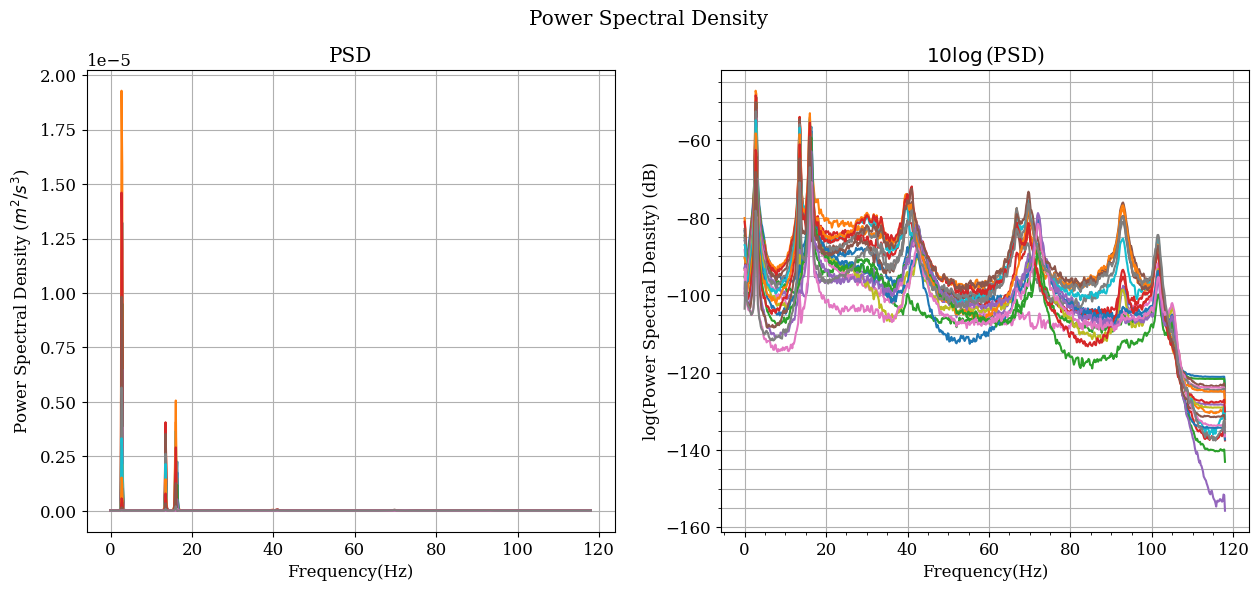

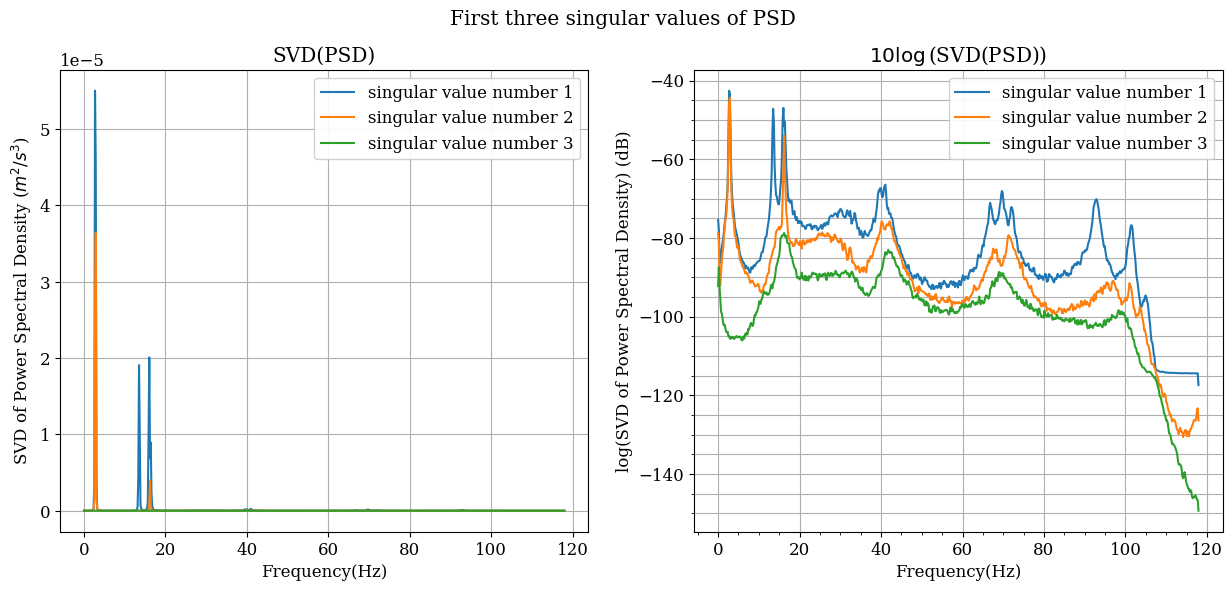

In [15]:
PSD_mat, f_psd = psd_func(pp_sig, dt,show_semilog=False,nseg=50,pov=0.5)
ss1, UU = svd_psd(PSD_mat, f_psd, show_semilog=False)
# ss1, UU = svd_psd(PSD_new[0], PSD_new[1], nxseg, num_chnl,show_semilog=False)

In [18]:
order = 70
PM_Coord_dict, PM_Stable_frequencies, PM_Stable_zetas, PM_Stable_phis = PolyMAX(
           pp_sig, dt, order, nseg=90, pov=0.5, criteria=[0.05, 0.05, 0.02], basis_order=1,
           no_mode_shape_stability=True, positve_psd=True, real_RST=True, real_M=True,
           mode_shape_based_on_all_found_modes=False,Num_poles_to_accept_a_mode=10)

Calculating M matrix for order: 1 ...
Calculating M matrix for order: 2 ...
Calculating M matrix for order: 3 ...
Calculating M matrix for order: 4 ...
Calculating M matrix for order: 5 ...
Calculating M matrix for order: 6 ...
Calculating M matrix for order: 7 ...
Calculating M matrix for order: 8 ...
Calculating M matrix for order: 9 ...
Calculating M matrix for order: 10 ...
Calculating M matrix for order: 11 ...
Calculating M matrix for order: 12 ...
Calculating M matrix for order: 13 ...
Calculating M matrix for order: 14 ...
Calculating M matrix for order: 15 ...
Calculating M matrix for order: 16 ...
Calculating M matrix for order: 17 ...
Calculating M matrix for order: 18 ...
Calculating M matrix for order: 19 ...
Calculating M matrix for order: 20 ...
Calculating M matrix for order: 21 ...
Calculating M matrix for order: 22 ...
Calculating M matrix for order: 23 ...
Calculating M matrix for order: 24 ...
Calculating M matrix for order: 25 ...
Calculating M matrix for order: 26

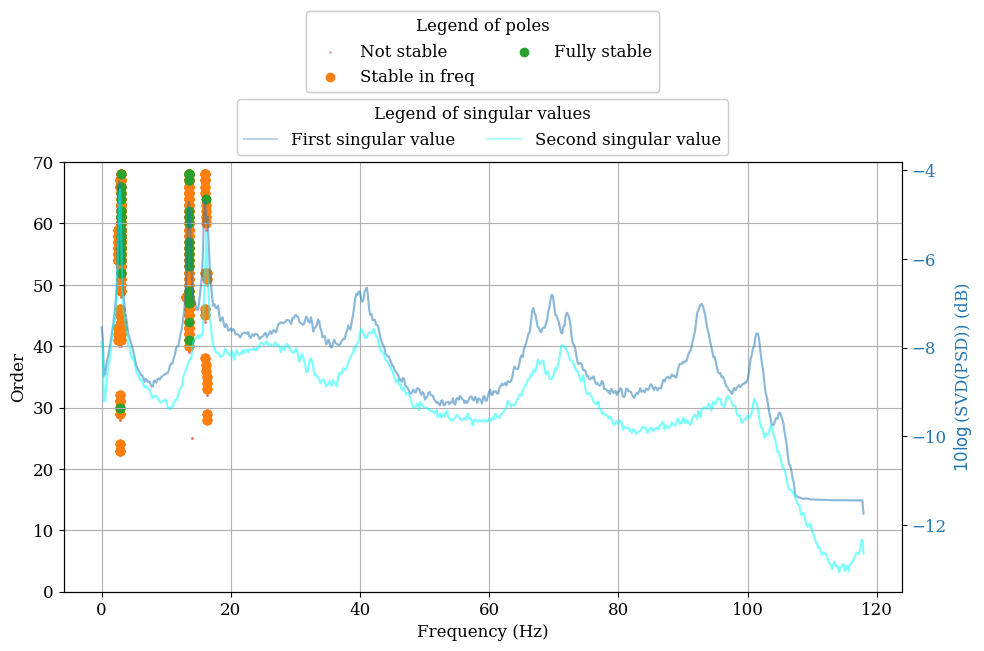

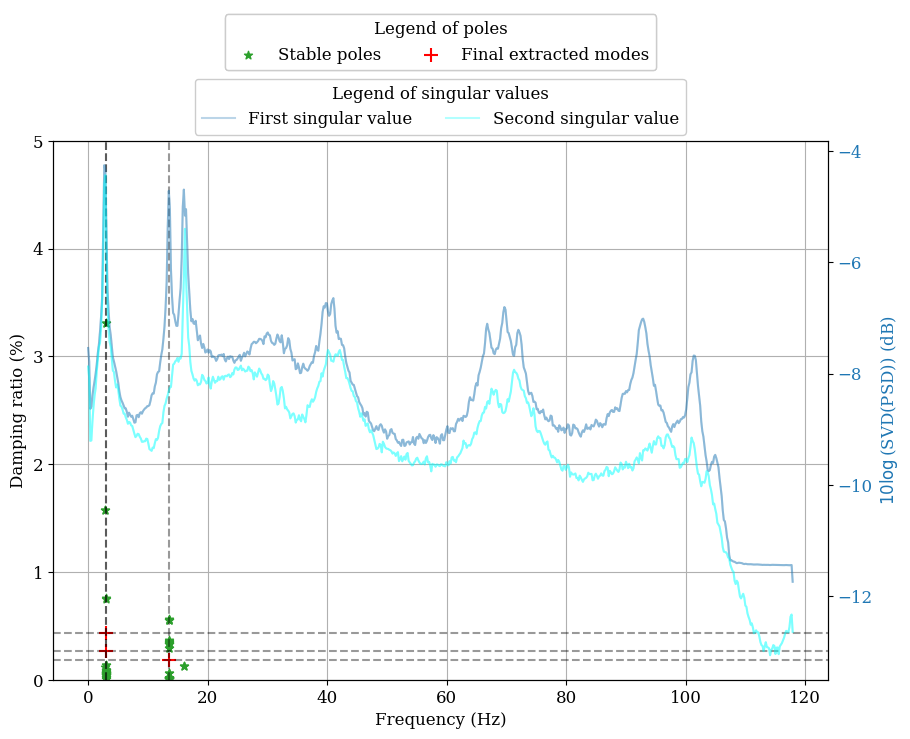

In [19]:
stabilization_diagram(PM_Coord_dict, PM_Stable_frequencies, PM_Stable_zetas, damp_ylim=[0,5], ylim=[0,order], xlim=0, add_PSD_SVD=True, f_psd=f_psd, ss1=np.log10(ss1), show_second_singular_value=True, without_mode_shape=False)

In [20]:
results_table(PM_Stable_frequencies, PM_Stable_zetas)

Frequencies  Damping Ratios
0     2.971097        0.004291
1     2.994817        0.002642
2    13.532503        0.001834

Calculating PSD...
Finding mode shapes ...


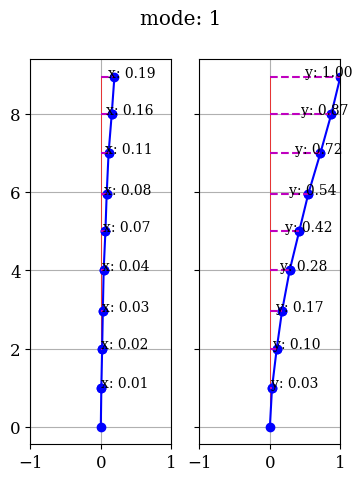

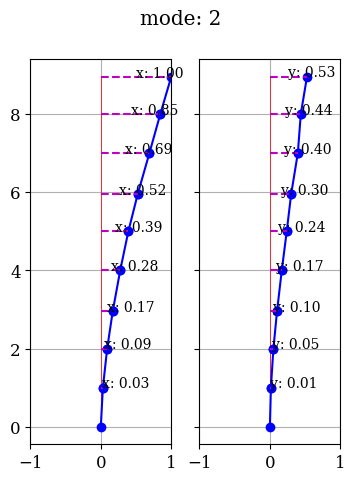

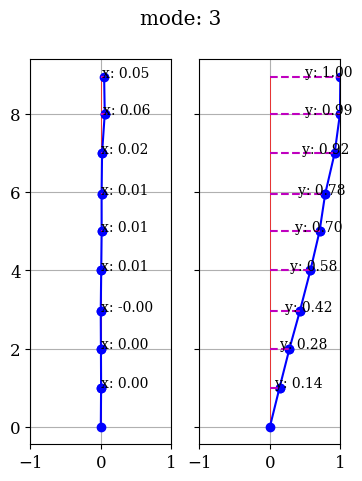

In [ ]:
freqs_to_show, damps_to_show, _ = choose_modes(PM_Stable_frequencies, PM_Stable_zetas, mode_numbers=[])
Mode_shapes_to_show = independent_mode_shape(freqs_to_show, damps_to_show, pp_sig, dt, nseg=50)

coord_file_name = 'coords_lumo.csv'

draw_mode_shapes(coord_file_name, list_mode_shapes=Mode_shapes_to_show, list_freqs=freqs_to_show, list_damps=damps_to_show, base_axis='z', base_axis_align='vertical')

# ITD on LUMO

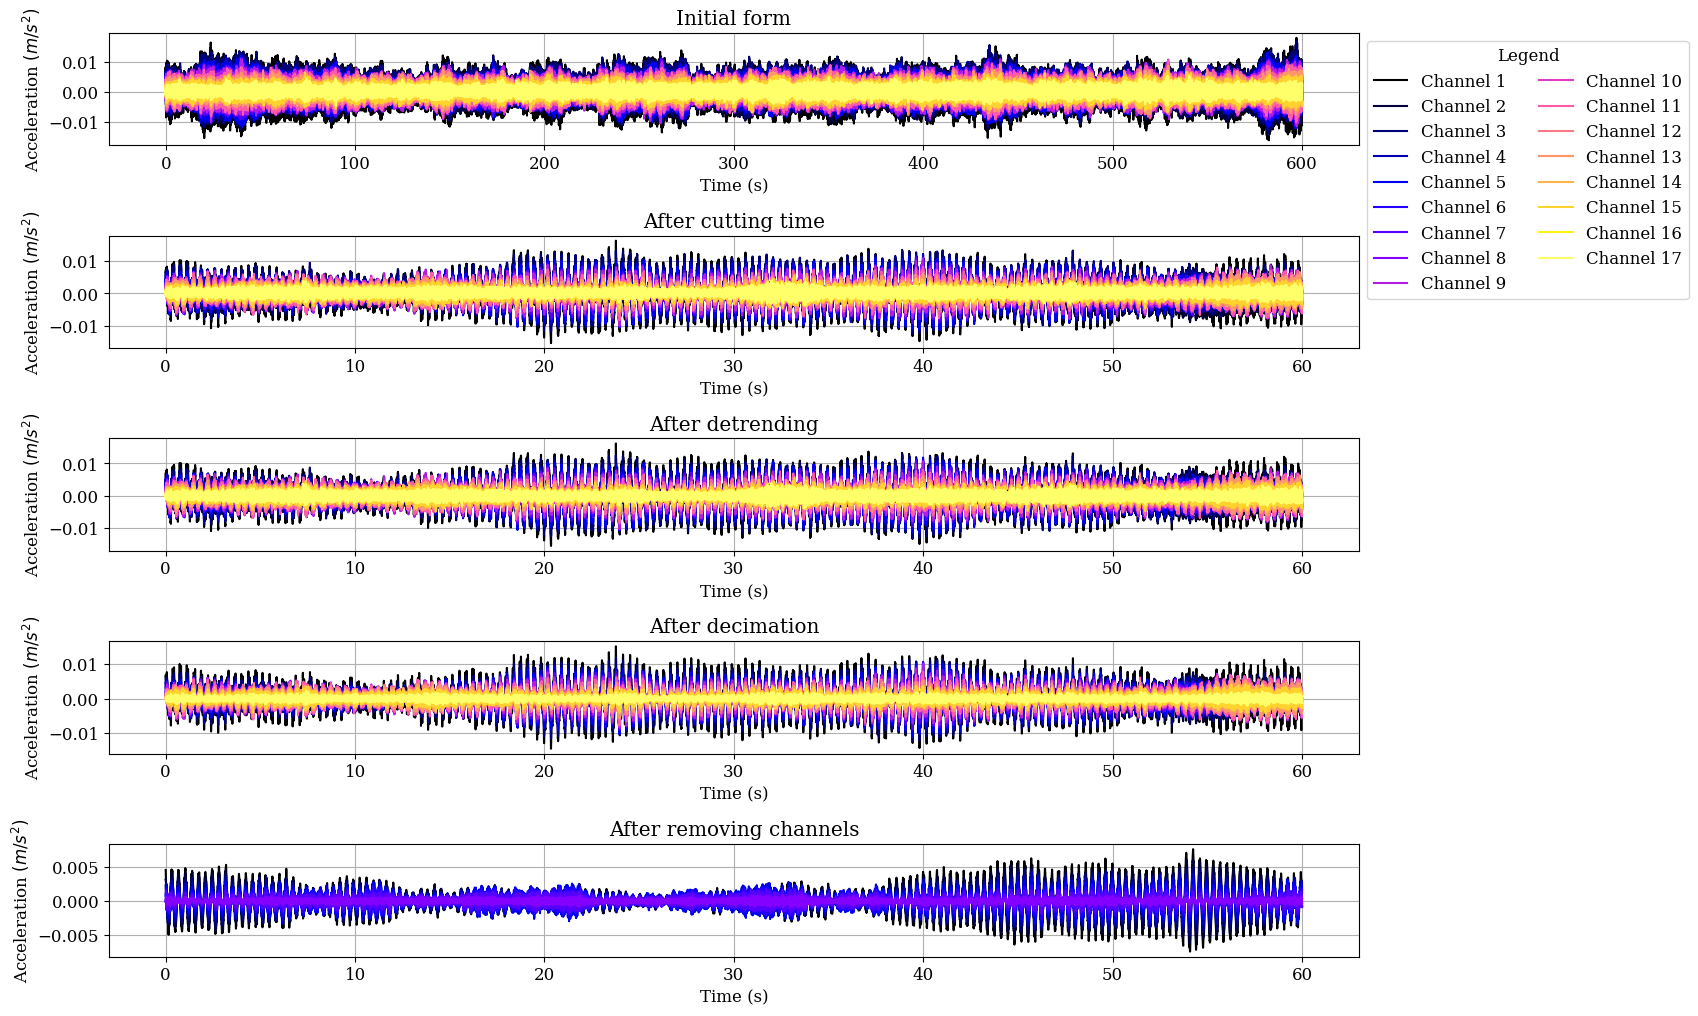

In [26]:
pp_sig_ITD, time_ITD = preprocess(extracted_y, t_qatar, do_detrend=True, time_limit=[0, 0.1], channels_to_remove=range(1,18,2), decimate_downsample=7, filter_lim=0)
dt_ITD = time_ITD[1]-time_ITD[0]

In [28]:
pp_sig_ITD = pp_sig_ITD[:, np.where(pp_sig_ITD.sum(axis=0) != 0)].reshape(pp_sig_ITD.shape[0],-1)
pp_sig_ITD.shape

(14152, 8)

In [ ]:
range(10)[1:6:2]

range(1, 6, 2)

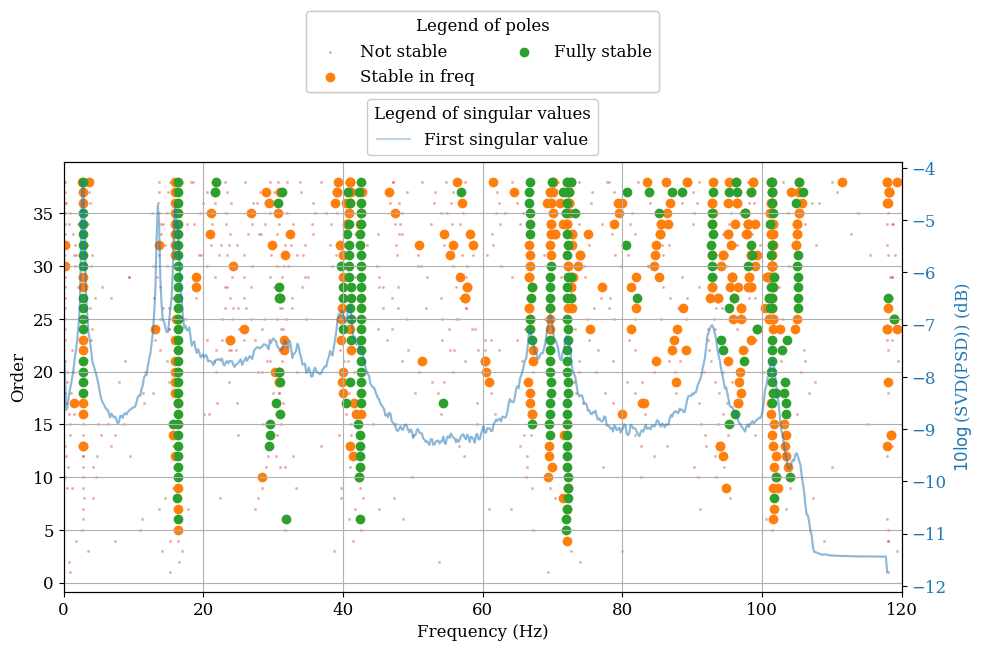

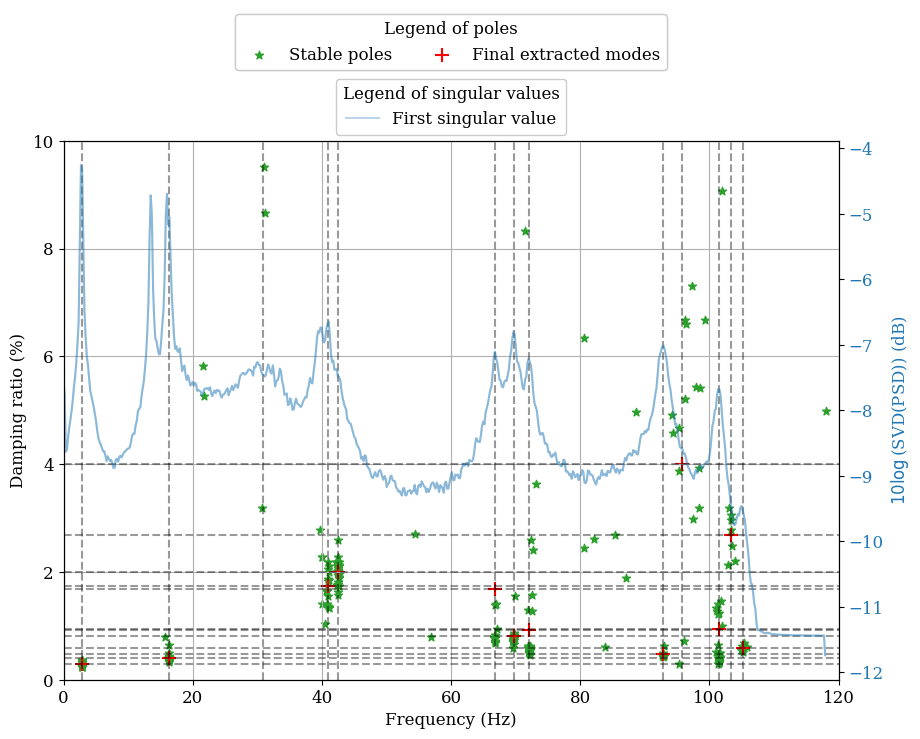

In [32]:
ITD_Coord_dict, ITD_Stable_frequencies, ITD_Stable_zetas = ITD_alg(pp_sig_ITD[:, 1:9:3], dt_ITD, order=40, criteria=[0.01,0.2,0.02] ,Num_poles_to_accept_a_mode=5)
stabilization_diagram(ITD_Coord_dict, ITD_Stable_frequencies, ITD_Stable_zetas ,xlim=[0,120], add_PSD_SVD=True, f_psd=f_psd, ss1=np.log10(ss1))

In [33]:
results_table(ITD_Stable_frequencies, ITD_Stable_zetas)

Frequencies  Damping Ratios
0      2.813764        0.002888
1     16.334494        0.004060
2     30.904694        0.125877
3     41.009406        0.017418
4     42.515940        0.020032
5     66.838468        0.016873
6     69.697619        0.008037
7     72.146124        0.009140
8     92.861274        0.004757
9     95.821921        0.040034
10   101.475238        0.009478
11   103.376995        0.026835
12   105.190385        0.005822

Calculating PSD...
Finding mode shapes ...


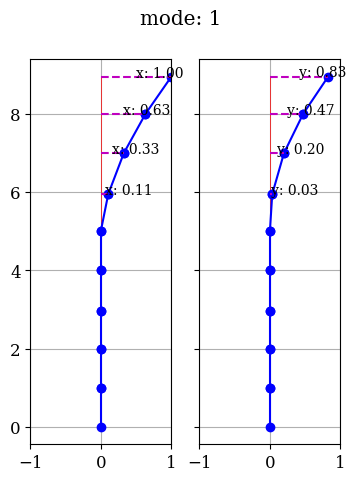

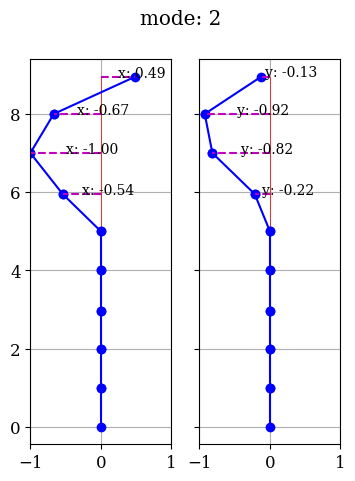

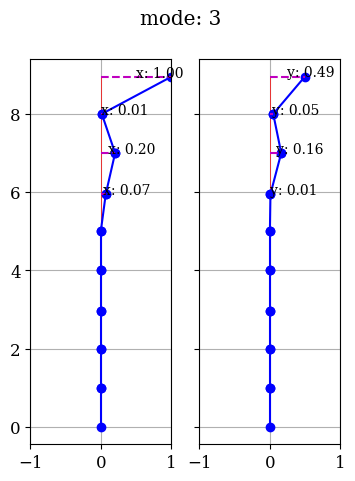

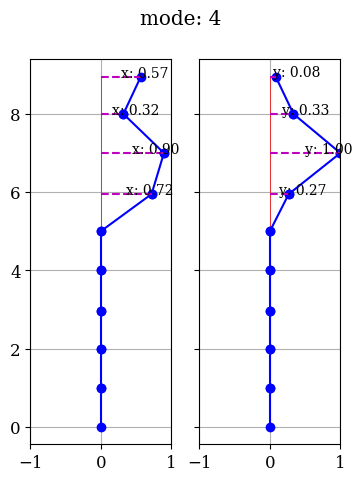

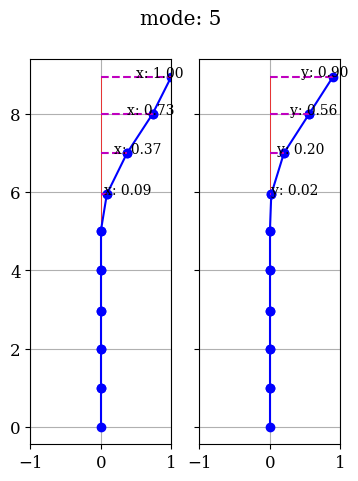

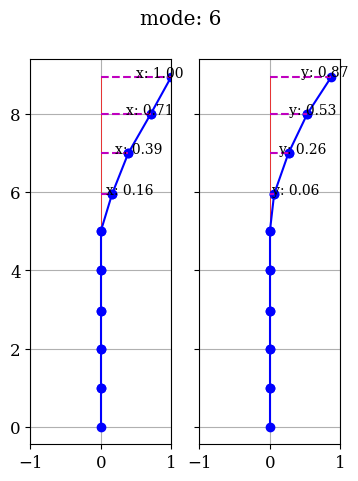

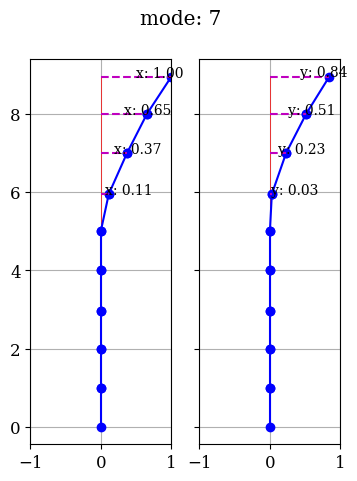

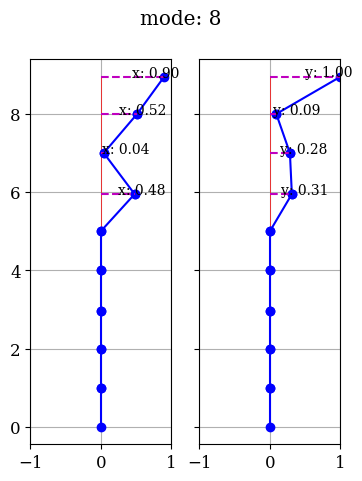

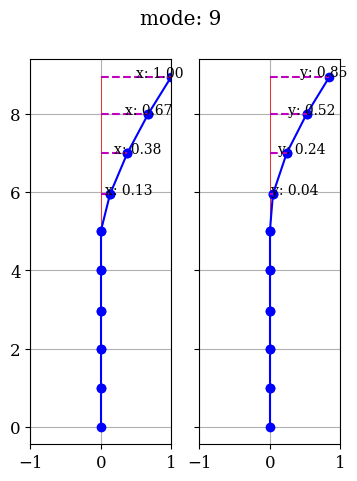

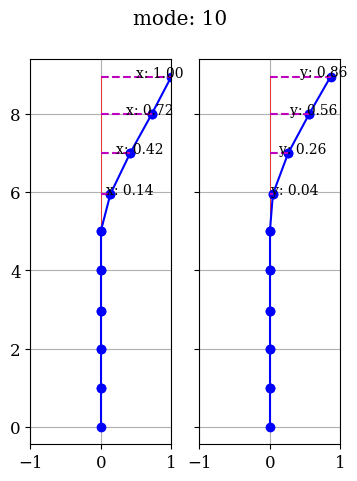

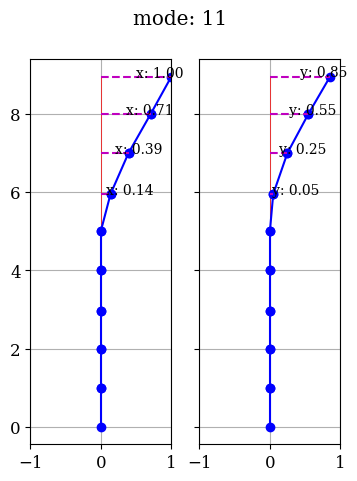

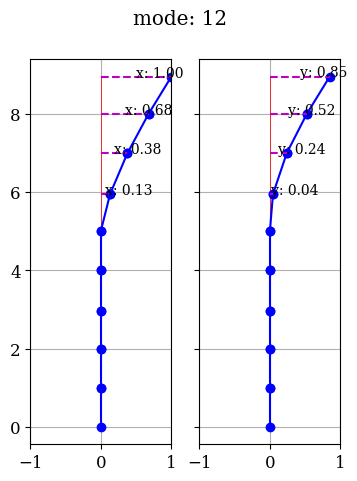

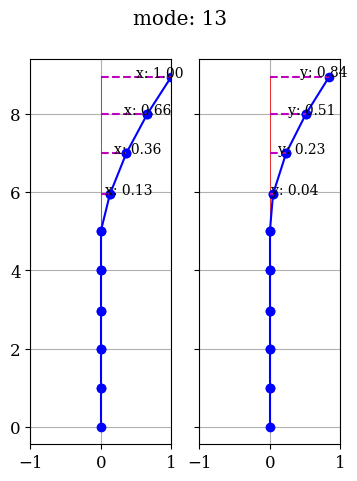

In [ ]:
freqs_to_show, damps_to_show, _ = choose_modes(ITD_Stable_frequencies, ITD_Stable_zetas, mode_numbers=[])
Mode_shapes_to_show = independent_mode_shape(freqs_to_show, damps_to_show, pp_sig_ITD, dt, nseg=10, pov=0.5, window='hann')

coord_file_name = 'coords_lumo.csv'

draw_mode_shapes(coord_file_name, list_mode_shapes=Mode_shapes_to_show, list_freqs=freqs_to_show, list_damps=damps_to_show, base_axis='z', base_axis_align='vertical')